In [67]:
#array op:
import numpy as np, itertools
#file op:
import json
from os import walk
#data science:
from scipy.optimize import least_squares
from scipy.interpolate import CubicSpline
#dfbgn:
import dfbgn
#lmfit:
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit
#timer:
import time
#visualization:
import pandas as pd
import datetime
#utilities:
import warnings

In [4]:
list_data = np.load('data/hxoy_data.npy', allow_pickle=True) #reload
list_data = list_data[()]
print(len(list_data))

25


general f_obj, RMSE: $\sqrt{\frac{1}{n}\sum^n_{i=1}(V_{pred} - V_{ab initio})^2}$

In [5]:
# useful analytics/statistics functions

## RMSE:
def RMSE(Y_pred, Y):
    #error between Y prediction and Y actual
    error = 0
    n = len(Y)
    for i in range(n):
        diff = (Y[i]-Y_pred[i])**2
        error += diff
    return np.sqrt(error/n)

## sech:
def sech(x):
    exp = np.exp(x)
    inv_exp = 1/exp
    return 2/(exp + inv_exp)

## horner scheme:
def horner(x, C):
    y = C[-1]
    for i in range(len(C)-2, -1, -1):
        y = y*x + C[i]
    return y

polynomial fit f_obj, minimize: $\sum_{i=1}^n |p(R_i) - V_i|^2$

In [6]:
'''
The models and objective functions
'''
'''Pair Potentials:'''
np.random.seed(13) #reprodicuibility

#for morse, the equilibrium distance is a good start point for r0

## First proposed model:
f_morse_pot = lambda r,a: np.exp(-r/a)

def f_poly(x, c): #general polynomial, evaluated at x by horner's scheme
    y = c[-1]
    for i in range(len(c)-2, -1, -1):
        y = y*x + c[i]
    return y
    
def f_monomial_diatomic_pot(r, coeffs, morse=False): #monomial pot - permutationally invariant functional 
    #r := r_i, the ith distance
    #coeffs := the coefficients, in increasing order of polynomial (0,1,2,...)
    #evaluate the polynomial by horner's scheme:
    y = r
    v = coeffs[-1]
    for i in range(len(coeffs)-2, -1, -1):
        #i := power of the polynomial
        if morse and i > 0: #exclude the constant for morse
            y = f_morse_pot(r,i)
        v = v*y + coeffs[i]
    return v

## second proposed model:
def f_diatomic_pot_lr(C, *args):
    #C = fitted coefficients, [0:len(C)] is the polynomials' coefficients c_i, [-1] is the nonlinear decaying exp coeff r_0
    ##uses *args because dfbgn doesnt accept **kwargs
    #args[0] := r, the internuclear distance
    #args[1] := Z = (Z_1, Z_2), the tuple of nuclear charges
    #M, the max polynomial degree (= len(C)-2)
    r0 = C[-1]
    r = args[0]
    Z = args[1]
    M = len(C)-2
    y = np.exp(-r/r0)
    #V = (Z[0]*Z[1])/r + C[0]
    V = (Z[0]*Z[1] + C[0])/r*(1+C[1]*(r**6))
    
    poly_V = C[-2]
    #for i in range(M-1, 1, -1): 
    for i in range(M-1, 2, -1):
        poly_V = poly_V*y + C[i]
        #print(i, poly_V, C[i])
    '''
    #non horner version:
    poly_V = 0
    #for i in range(2, M):
    for i in range(3, M): 
        poly_V += C[i]*(y**(i-3))
        #print(i, poly_V)
        #poly_V = poly_V*y + C[i-2]
    '''
    #poly_V *= ((1-y)/(r**3 + C[1]))**2
    poly_V *= ((1-y)/(r**3 + C[2]))**2
    V += poly_V
    return V


## third propopsed model:
def f_diatomic_vdw(C, *args):
    #m free parameters:
    R = args[0]
    Z = args[1] #Zi x Zj
    m = args[2] #the maximum polynomial power
    # V_infty = args[1]

    # C[1] -> |C[1]|:
    if C[1] < 0:
        C[1] = -C[1]
    
    #operations:
    R2 = R*R; 
    
    #R4 = R2**2; R6 = R2*R4; 
    
    '''
    s = 1 + C[0]*R2 + C[1]*R4;
    p = s/(s + C[2]*R6);
    #p = 1/(C[0] + R6)
    q = C[3] + (C[4] + C[5]*R2)**2
    
    V = (Z/R)*p - (R/q)**2 +C[6]
    '''
    
    #################################################
    '''   
    specific, m=2:

    V(r)=c_0+A(r)/C(r),

    where

    A(r)=Z_{ij}(1/r+c_1  r)+c_2+c_3 r^2,

    B(r)=1+(c_4+c_5 r +c_6 r^2)r,

    C(r)=1+c_1 r^2 B(r)^2,

    c_1>0
    '''
    
    #7 free params:
    '''
    a = Z*(1/R + C[1]*R) + C[2] + C[3]*R2
    b = 1 + (C[4] + C[5]*R + C[6]*R2)*R
    c = 1 + C[1]*R2*(b**2)
    V = C[0] + a/c
    '''    

    ##################################################
    '''
    Generalized m free parameters:
    
    V(r)=c_0+A(r)/C(r),

    where

    A(r)=Z_{ij}(1/r+c_1 r)+c_2+c_3 r2+ ...+c_{2m-1}r^{2m-2}

    B(r)=1+(c_{2m}+c_{2m+1} r +...+c_{3m} r^m)r,

    C(r)=1+c_1 (r B(r))2,

    c_1>0
    '''
    
    '''
    '''
    
    # operations on V:
    
    # a by horner:
    C_temp = C[3 : 2*m] # index [3, 2m-1]
    y = horner(R, C_temp)*R2 #multiply by R^2 at the end
    a = Z*(1/R + C[1]*R) + C[2] + y
    
    # b by horner:
    C_temp = C[2*m : 3*m + 1] # index [2m, 3m]
    y = horner(R, C_temp)
    b = 1 + y*R
    
    c = 1 + C[1]*((R*b)**2)
    
    V = C[0] + a/c
    return V

## CHIPR models:
### for OH+:
def f_diatomic_chipr_ohplus(C, *args):
    '''
    #free parameters, length = 19, for (m, M) = (4, 4): 
    R_oh = C[0] 
    omega = C[1] 
    a = C[2:6]; 
    A = C[6:10];
    zeta = C[10];
    miu = C[11:15];
    chi = C[15:19];
    
    #fixed parameters:
    R = args[0]
    
    #operations:
    R_oh_2 = R_oh**2; R_oh_3 = R_oh_2*R_oh
    
    x = (sech((R - zeta)*miu[0])**chi[0])*a[0] \
    + (sech((R - zeta*R_oh)*miu[1])**chi[1])*a[1] \
    + (sech((R - zeta*R_oh_2)*miu[2])**chi[2])*a[2] \
    + (sech((R - zeta*R_oh_3)*miu[3])**chi[3])*a[3]
    x2 = x**2; x3 = x2*x; x4 = x3*x
    V = 8*(R**(-omega))*(x*A[0] + x2*A[1] + x3*A[2] + x4*A[3])
    '''
    
    ###################################################################
    # CHIPR with (3m + M + 3) parameters:
    R = args[0]
    Z = args[1]
    M = args[2] #outer M
    m = args[3] #inner m
    
    omega = C[0]
    zeta = C[1]
    R_oh = C[2]
    miu = C[3:m+3]
    chi = C[m+3:2*m+3]
    a = C[2*m+3:3*m+3]
    A = C[3*m+3:3*m+3+M]
    
    #compute x, using inner m:
    x = 0
    Ri = 1 #R^i
    for i in range(m):
        theta = (R - zeta*Ri)*miu[i]
        x += (sech(theta)**chi[i])*a[i]
        Ri *= R_oh #compute the power of R_oh
    
    # horner for M polynom:
    y = horner(x, A)*x # the polynomial has 1 extra degree
    V = y*(Z*(R**(-omega)))
    return V


    
## Deiters + Neumaier model:
def f_diatomic_dn(C, *args):
    #5 free parameters (\alpha is placed last in the array):
    R = args[0]
    R2 = R**2; R_1 = 1/R; R8 = R2**4;
    V = (C[0]*np.exp(-2*C[3]*R))*(C[3] + R_1) - (C[1]*R2)/(C[2] + R8) + C[4]
    return V


## Deiters + Sadus model:
def f_diatomic_ds(C, *args):
    #8 free parameters:
    R = args[0]
    R2 = R**2; R6 = R2**3;
    numer = (C[0]/R)*(np.exp(C[1]*R + C[6]*R2)) + C[2]*(np.exp(C[3]*R)) + C[4]
    denom = 1 + C[5]*R6
    return numer/denom + C[7]

## LJ pot:
def f_lj_pot(C, *args):
    #2 params
    R = args[0]
    R2 = R*R; R4 = R2*R2; R6 = R4*R2; R12 = R6*R6
    return (C[0]/R12) - (C[1]/R6)

'''Objective functions'''

def f_poly_obj(R, V, coeffs, F, poly_par): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], coeffs, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_obj2(C, *args): #least squares for all polynomials 
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    ssum = 0
    length = len(R)
    for i in range(length):
        p = F(R[i], C, morse)
        diff = (p-V[i])**2
        ssum += diff
    return ssum

def f_poly_res(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = (p-V[i])**2
    return residuals

def f_poly_res2(C, *args): #residuals function
    #R = vector of distances
    #V = vector of energies
    #F = polynomial function
    #coeffs = coefficients vector
    #poly_par = polynomial function parameters {"M" = max degree,"morse" = switch for morse fun}
    F = args[0]
    R = args[1]
    V = args[2]
    poly_par = args[-1]
    M = poly_par["M"]; morse = poly_par["morse"]
    length = len(R)
    residuals = np.zeros(length)
    for i in range(length):
        p = F(R[i], C, morse)
        residuals[i] = p-V[i]
    return residuals

def f_obj_diatomic_pot_res(C, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1] #the energy vector
    #R = args[2] #the distance vector
    #Z = args[3] #nuclear charges of two atoms
    #error = 0 
    n = len(V)
    residuals = np.zeros(n)
    V_pred = F(C, *args[2:])
    residuals = np.square(V_pred - V)
    #for i in range(n):
    #    v_pred = F(C, args[3:])
    #    residuals[i] = V[i]-v_pred
    return residuals.flatten()

############ lmfit version of objective functions ##############

def f_obj_diatomic_pot_res_lmfit(C_param, *args):
    #the objective function to be fitted, in residuals form, for least squares
    #C = coefficients to be fitted, dictionary form {""}
    #args[0] = function to be fitted, returns predicted data, Y_pred
    #args[1] = vector of actual data, Y
    #args[2:] = args of args[0]
    F = args[0]
    V = args[1]
    n = len(V)
    residuals = np.zeros(n)
    # Transform dictionary to array:
    C = np.array([C_param[key] for key in C_param]) #ordered array of parameters, scipy convention
    V_pred = F(C, *args[2:])
    #residuals = np.square(V_pred - V)
    residuals = V_pred - V
    return residuals.flatten()

In [7]:
# multiple-start for local optimizers:
def lmfit_params_wrap(C, mode): #wrapper for lmfit parameters
    C_params = Parameters() #lmfit parameters
    if mode == "default":
        for i, c in enumerate(C):
            C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)
    elif mode == "alternate":
        #vector with alternating sign:
        for i, c in enumerate(C):
            val = c
            if i%2 == 0:
                val = -c
            C_params.add(name="c"+str(i), value=val, min=-np.inf, max=np.inf)
    return C_params

def multistart(n, delta, F, V, *F_args, len_C=100, mode='default', verbose=False):
    #randomize by power x2 each loop and alternate sign:
    #n =  max loop
    #delta = minimum RMSE
    #the data are global var
    pwr = 1
    min_rmse = np.inf
    #min_C = np.zeros(5)
    min_C = np.zeros(len_C)
    for k in range(n):
        C0 = np.random.uniform(-1, 1, len_C)*pwr
        C_params = lmfit_params_wrap(C0, mode)
        while True: #NaN exception handler:
            try:
                #minimization routine and objective function here:
                out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *F_args), method="bfgs")
                break
            except ValueError:
                #reset C until no error:
                if verbose:
                    print("ValueError!!, resetting C")
                C0 = np.random.uniform(-1, 1, len_C)*pwr
                C_params = lmfit_params_wrap(C0, mode)
                continue
        #transform out.params to C array:
        C = np.array([out.params[key] for key in out.params])
        #special condition for 3rd ansatz: C0->|C0|, C3->|C3|:
        #C[0] = np.abs(C[0]); C[3] = np.abs(C[3])
        #get the predicted V
        V_pred = F(C, *F_args)
        rmse = RMSE(V_pred, V)
        #get the minimum rmse:
        if rmse < min_rmse:
            min_rmse = rmse
            min_C = C
        #stop if delta is satisfied:
        if min_rmse <= delta:
            break
        #increase power or alternate sign
        if k%2 != 0:
            pwr *= 1e-1
        else:
            pwr *= -1 #alternate sign
    return min_rmse, min_C

def multiple_multistart(k, n, delta, F, V, *F_args, len_C=30, mode="default", verbose=False):
    #k = number of restarts
    min_rmse = np.inf; min_C = None
    for i in range(k):
        res = multistart(n, delta, F, V, *F_args, len_C=len_C, mode=mode)
        print(i,"th round is done")
        rmse = res[0]; C = res[1];
        if rmse < min_rmse:
            min_rmse = rmse
            min_C = C
            print("RMSE = ",rmse)
        if rmse <= delta:
            break
    return min_rmse, min_C

In [8]:
# performance measurements:
def evaluate_efficiency(Fs, N, args, len_C):
    # function to evaluate the efficiency of a list of functions Fs by computing it N-numbers of time
    # args = list of arguments for each function
    times = []
    C = np.random.rand(len_C) #any vector works as long as it accomodates the minimium size
    for i, F in enumerate(Fs):
        #eval each function
        start = time.time()
        for j in range(N):
            F(C, *args[i])
        diff = time.time()-start
        times.append(diff)
    return times

### train on OH+ data of Xavier

In [9]:
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#test on idx 1, train on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

In [14]:
#train using polynomial fit
M = 13 #max degree of polynomial
poly_par = {"M": M, "morse" : False}
#c = np.zeros(M)
#f = f_poly_obj(R, V, c, f_monomial_diatomic_pot, poly_par)
#print(f)
#test using numpy's polyfit:
c = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_obj(R, V, c[::-1], f_monomial_diatomic_pot, poly_par)
print("training error = ",e)
p = np.poly1d(c)
p_V = p(R)

training error =  5.382597244179081e-05


### test on OH+ data of Werner

In [30]:
idx = 1
R_test = list_data[qidxs[idx]]["R"]
V_test = list_data[qidxs[idx]]["V"]
p_V_test = p(R_test)
e = f_poly_obj(R_test, V_test, c[::-1], f_monomial_diatomic_pot, poly_par)
print("testing error = ",e)
print("testing RMSE = ",RMSE(V_test, p_V_test))

testing error =  2.9877720569352594e-05
testing RMSE =  0.005466051643494836


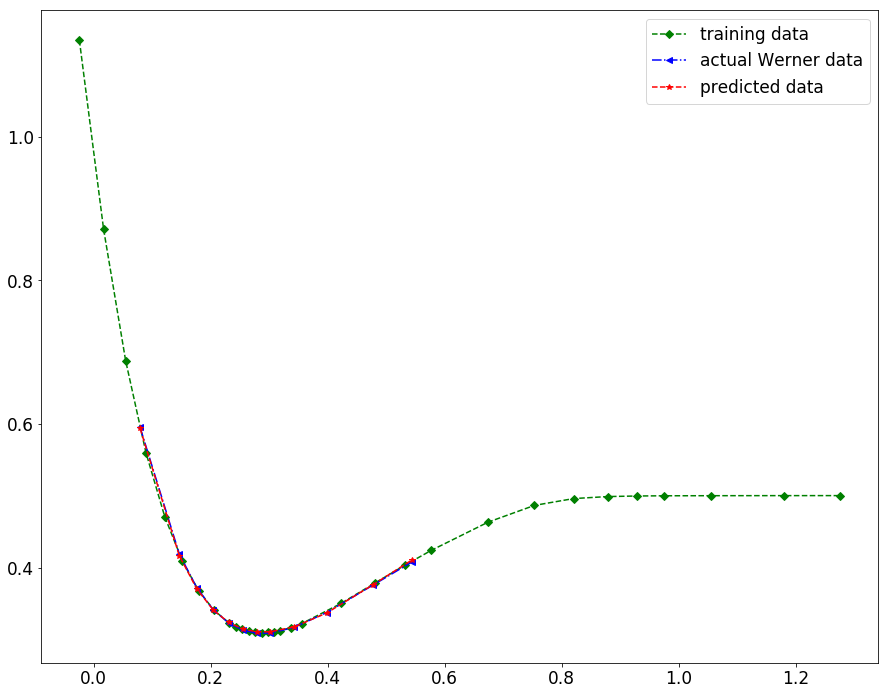

In [16]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 12))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), p_V_test, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

### Cubic spline

training RMSE = 0.0
testing RMSE = 0.0035166731030738677


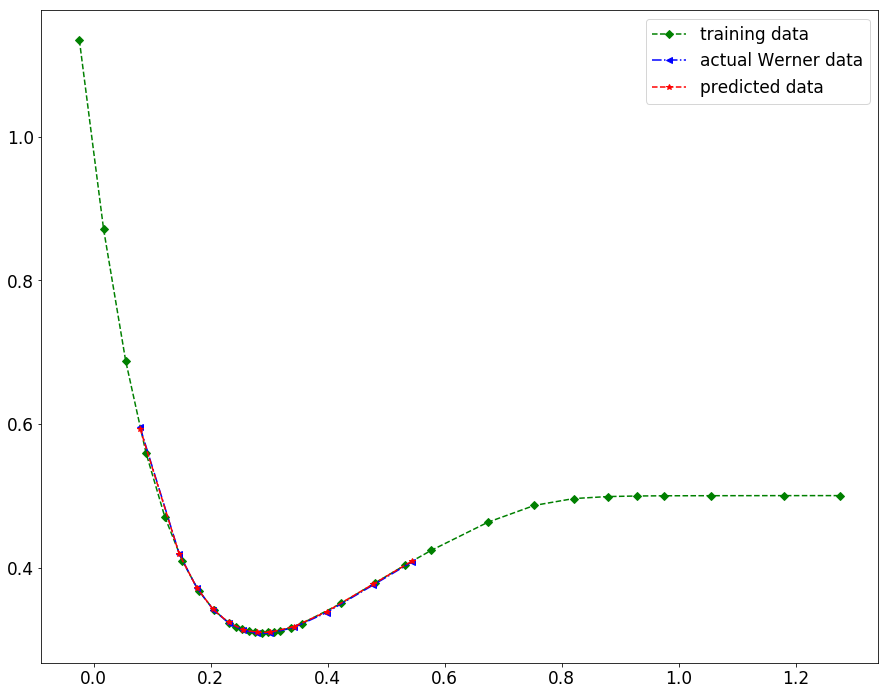

In [29]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
rmse = RMSE(V, V_pred)
print("training RMSE =",rmse)
plt.subplots(figsize=(15, 12))

#predict Werner's V:
V_pred = cs(R_test)
rmse = RMSE(V_test, V_pred)
print("testing RMSE =",rmse)
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual Werner data", "predicted data"])

test RMSE = 0.008246436812486388


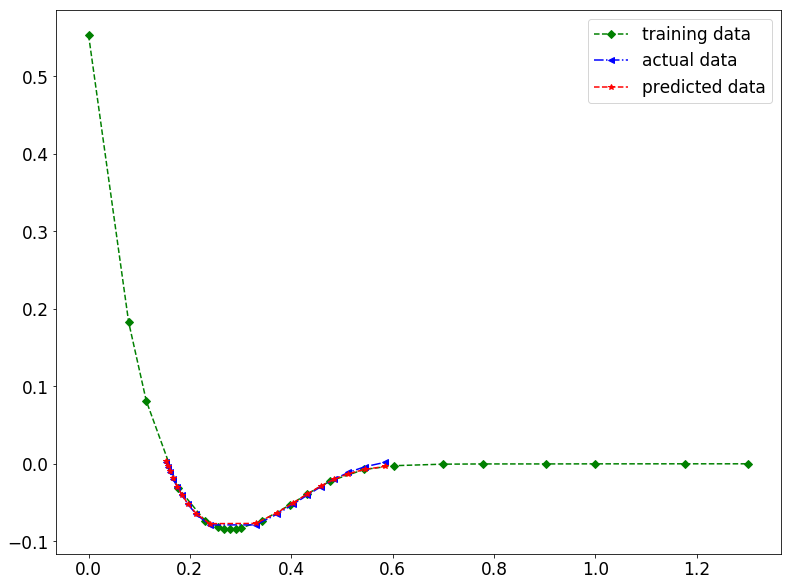

In [38]:
mol = "OH"
qidxs = query_many_vars_indices([mol, "$A^2\Sigma^+$"], ["mol", "state"], list_data)
newidxs = qidxs[1:3]
trainid = newidxs[0]; testid = newidxs[1]
R = list_data[trainid]["R"]; V = list_data[trainid]["V"] # training data
R_test = list_data[testid]["R"]; V_test = list_data[testid]["V"]# test data

cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R_test)
print("test RMSE =", RMSE(V_test, V_pred))

plt.subplots(figsize=(13, 10))
plt.plot(np.log10(R), V, "g--D")
plt.plot(np.log10(R_test), V_test, "b-.<")
plt.plot(np.log10(R_test), V_pred, "r--*")
plt.legend(["training data","actual data", "predicted data"])

### Model 041021

residual =  [6.26993857e-08 3.37775687e-07 1.24525425e-10 1.31078826e-07
 1.00621484e-07 4.83974034e-09 2.49985341e-08 6.62266730e-08
 4.84628518e-08 2.75739942e-08 9.70722669e-09 6.67285361e-10
 2.00686547e-09 1.10201622e-08 2.24702251e-08 3.06994101e-08
 3.28100399e-08 1.62031885e-08 3.94437897e-11 2.14749242e-07
 4.29919692e-11 2.09144001e-07 1.04761908e-07 4.62991031e-09
 5.99056493e-10 9.06920085e-11 4.12289095e-12 5.78492933e-13
 7.82263030e-13 9.26641495e-13 3.90367332e-12 5.51563500e-11]
RMSE =  0.00021390044569069021

`xtol` termination condition is satisfied.
Function evaluations 284, initial cost 3.9022e+36, final cost 1.3901e-04, first-order optimality 4.29e+18.
`xtol` termination condition is satisfied.
RMSE =  0.002947606656112963

RMSE = 0.0

`ftol` termination condition is satisfied.
Function evaluations 307, initial cost 2.0771e+10, final cost 1.1915e-01, first-order optimality 5.25e-02.
`ftol` termination condition is satisfied.
RMSE =  0.08629657007652229


C:\Users\beryl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


'\nZ = (1,1) #reduce the effect of nuclear charge:\nres = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")\nprint(res.message)\nV_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]\nprint("RMSE = ",RMSE(V_pred, V))\nplt.subplots(figsize=(15, 12))\nplt.plot(np.log(R), V, "bD")\nplt.plot(np.log(R), V_pred)\nplt.title("nonlinear diatomic with least squares, degree = "+str(M)+"; Z=1")\n'

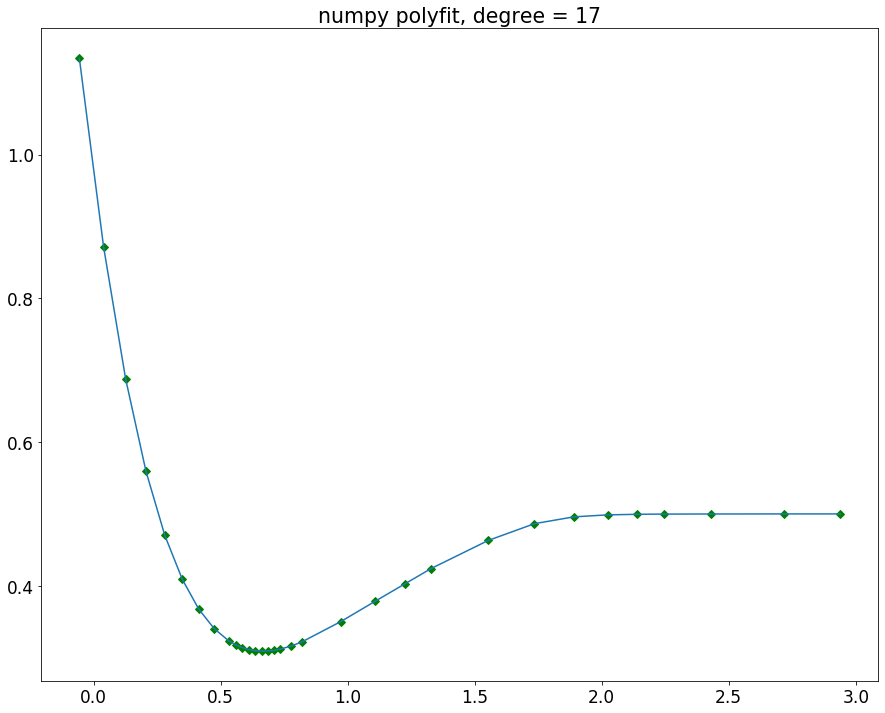

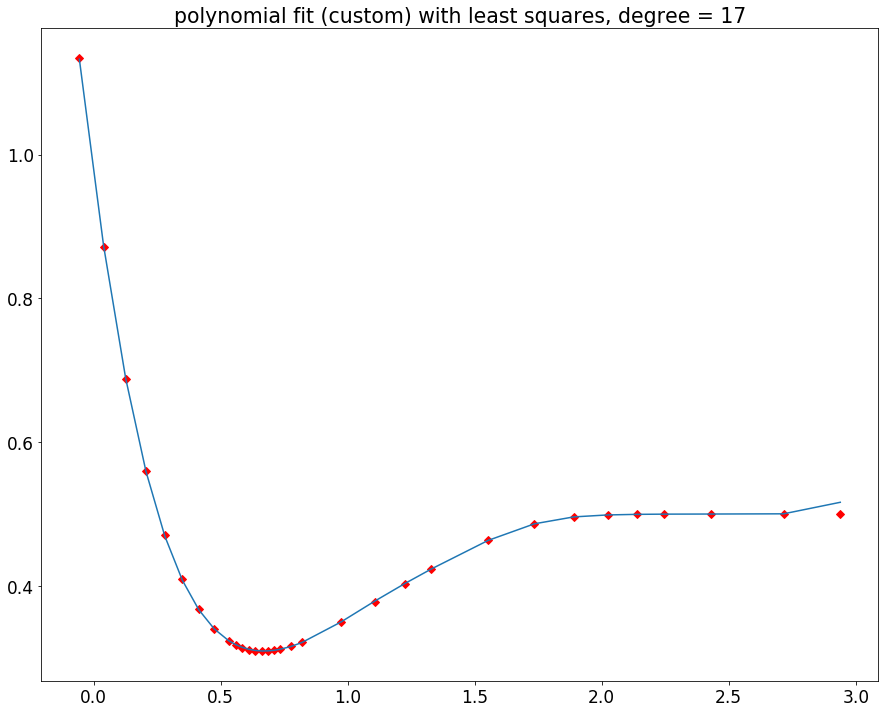

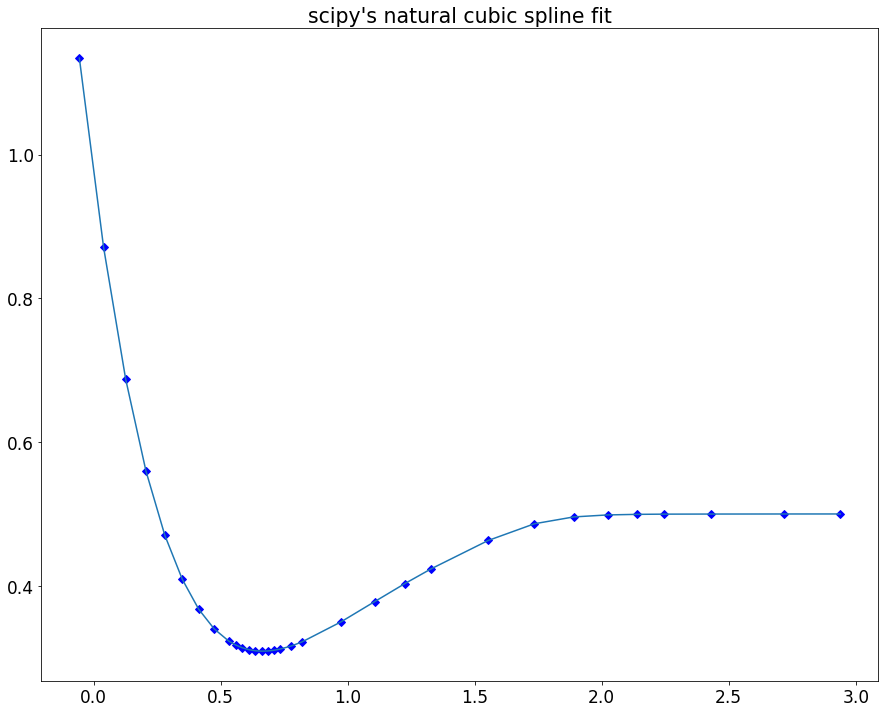

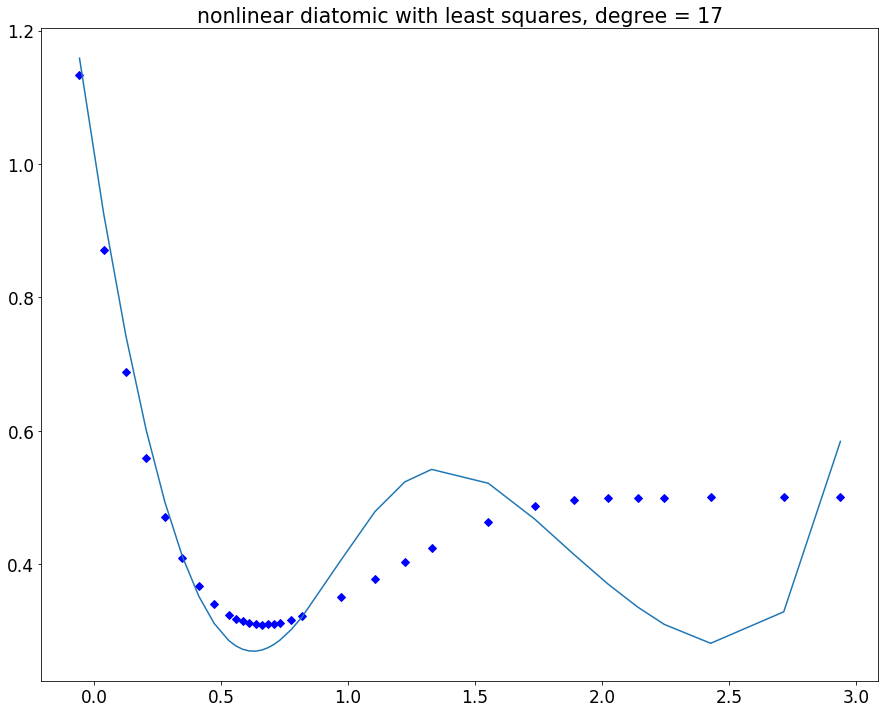

In [58]:
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 17})

mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
#train and test on idx 4:
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]
M = 17
#C0 = np.random.uniform(0, 1, size=(M)) #to avoid division by 0
C0 = np.zeros(M) + 1e-2
Z = (1, 8) #atomic number of atom_1 and atom_2 (permutationally symmetric)
poly_par = {"M":M, "morse":False}


C = np.polyfit(R, V, M) #automatic fit by numpy
e = f_poly_res(C[::-1], f_monomial_diatomic_pot, R, V, poly_par)
print("residual = ",e) #the residual function is correct
#p = np.poly1d(C)
#V_pred = p(R)
V_pred = [f_monomial_diatomic_pot(r, C[::-1], poly_par["morse"]) for r in R] #doublecheck the residual function
print("RMSE = ",RMSE(V_pred, V)) #the polynomial function is correct
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "gD")
plt.plot(np.log(R), V_pred)
plt.title("numpy polyfit, degree = "+str(M))
print()

#using polynomial fit but manual leastsquares:
#C0 = C[::-1] #look at the correct C
res = least_squares(f_poly_res2, C0, args=(f_monomial_diatomic_pot, R, V, poly_par), verbose=1, method="lm")
print(res.message)
V_pred = np.array([f_monomial_diatomic_pot(r, res.x, poly_par["morse"]) for r in R])
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "rD")
plt.plot(np.log(R), V_pred)
plt.title("polynomial fit (custom) with least squares, degree = "+str(M))
print()

#cubic spline:
cs = CubicSpline(R, V, bc_type='natural')
V_pred = cs(R)
print("RMSE =", RMSE(V, V_pred))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("scipy's natural cubic spline fit")
print()

#using the 2nd proposed method:
#soln = dfbgn.solve(f_obj_diatomic_pot_lr, C0, args=(f_diatomic_pot_lr, V, R, Z))
#print(soln) #dfbgn fails

res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M))

'''
Z = (1,1) #reduce the effect of nuclear charge:
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_pot_lr, V, R, Z), verbose=1, method="lm")
print(res.message)
V_pred = [f_diatomic_pot_lr(res.x, r, Z) for r in R]
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("nonlinear diatomic with least squares, degree = "+str(M)+"; Z=1")
'''

### Models 111021

In [10]:
# molecule OH+
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
idx = 4
R = list_data[qidxs[idx]]["R"]
V = list_data[qidxs[idx]]["V"]

`xtol` termination condition is satisfied.
Function evaluations 3948, initial cost 4.0998e+10, final cost 5.1878e-07, first-order optimality 3.10e-06.
`xtol` termination condition is satisfied.
RMSE =  0.012048278085106202
C after fit [ 9.05630307e-01 -1.28993076e+00 -1.45450972e+00  1.07894759e+00
  1.01893458e-01  4.45684978e-01  7.55404090e-01  8.11020980e-01
  4.95552683e+01  3.47166593e-02  7.47944990e-01  8.37140439e-01
  2.51021962e-02  1.40745821e+00  1.81352849e-02  6.77094385e+00
 -7.19693716e+00  5.97248719e-01  8.07254359e-01]
RMSE =  0.00013761279687157723


Text(0.5,1,'OH+ CHIPR lmfit')

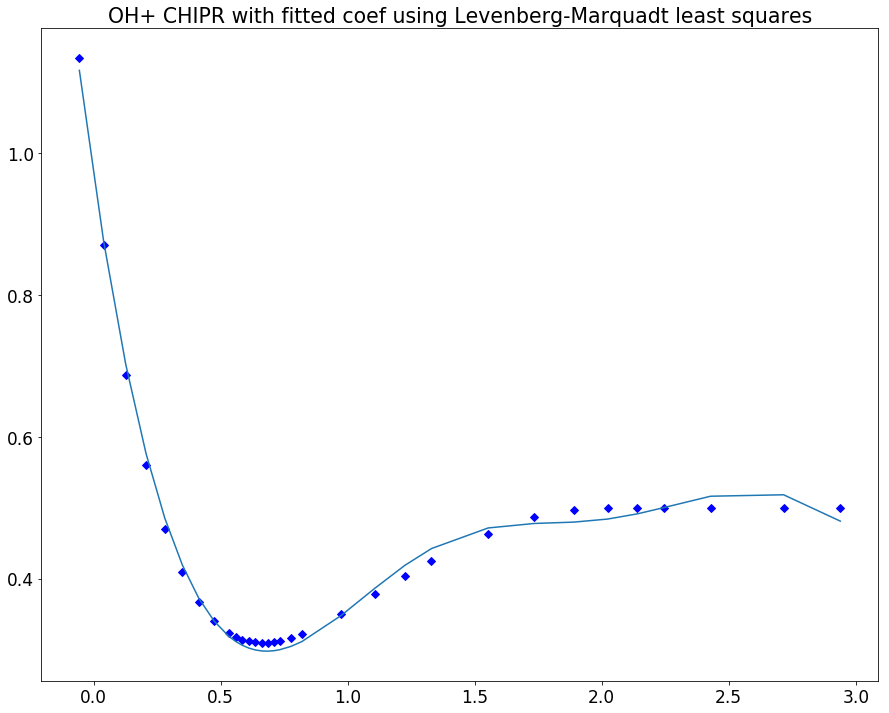

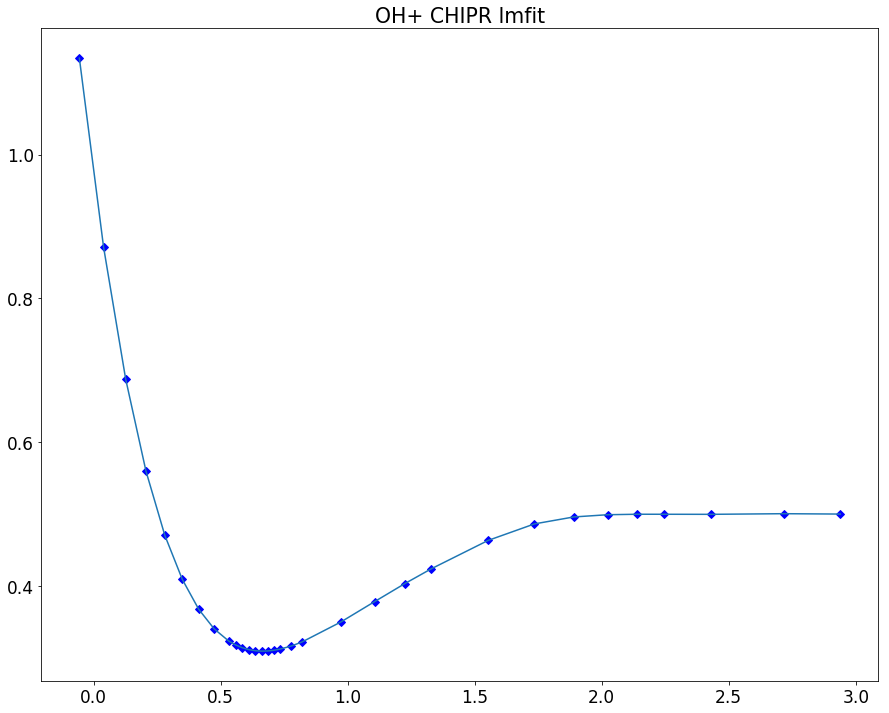

In [47]:
#CHIPR:
'''
C = np.array([8.57082, 0.921,
              -3.56097,  0.238234, 2.40785, 0.656067,
              0.378471, 1.7461, 5.91989, 8.5025,
              0.00683275,
              0.255374, 0.75669, 0.0664867, 0.358579,
              1.90036, 0.952497, 45.2516, 1.36563
             ]) #for chipr, from supp https://pubs.acs.org/doi/suppl/10.1021/acs.jpca.8b12005/suppl_file/jp8b12005_si_001.pdf
V_pred = f_diatomic_chipr_ohplus(C, R)
shift_O = 1313.9*0.00038088
print("RMSE = ",RMSE(V_pred+shift_O, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred+shift_O) #shift by 0.5
plt.title("OH+ CHIPR with Coeff from supp (and shifted by molar ionization energy)")
F = f_obj_diatomic_pot_res(C, f_diatomic_chipr_ohplus, V, R)
'''


##refit using LM LS:
m = M = 4; # default setting from paper
len_C = 3*m + M + 3
Z = 8
C0 = np.random.uniform(0, 1, len_C)
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_chipr_ohplus, V, R, Z, M, m), verbose=1, method="lm")
print(res.message)
V_pred = f_diatomic_chipr_ohplus(res.x, R, Z, M, m)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ CHIPR with fitted coef using Levenberg-Marquadt least squares")

##refit using lmfit:
C0 = np.random.uniform(0, 1, len_C)+1e-9
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)
out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_chipr_ohplus, V, R, Z, M, m), method='leastsq')
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_chipr_ohplus(C, R, Z, M, m)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ CHIPR lmfit")

C after fit [2.48049922e+01 7.08999234e+01 1.23990514e+03 2.55740800e+00
 4.84834053e-01]
RMSE =  0.01799576794236503
C after fit [ 1.00000000e-09 -1.41270504e+07 -6.53574466e-01 -4.13183564e-03
 -1.14400843e-03  1.00000000e-09  0.00000000e+00  1.08967434e+00]
RMSE =  121802704.1343347


Text(0.5,1,'OH+ Deiters-Sadus lmfit')

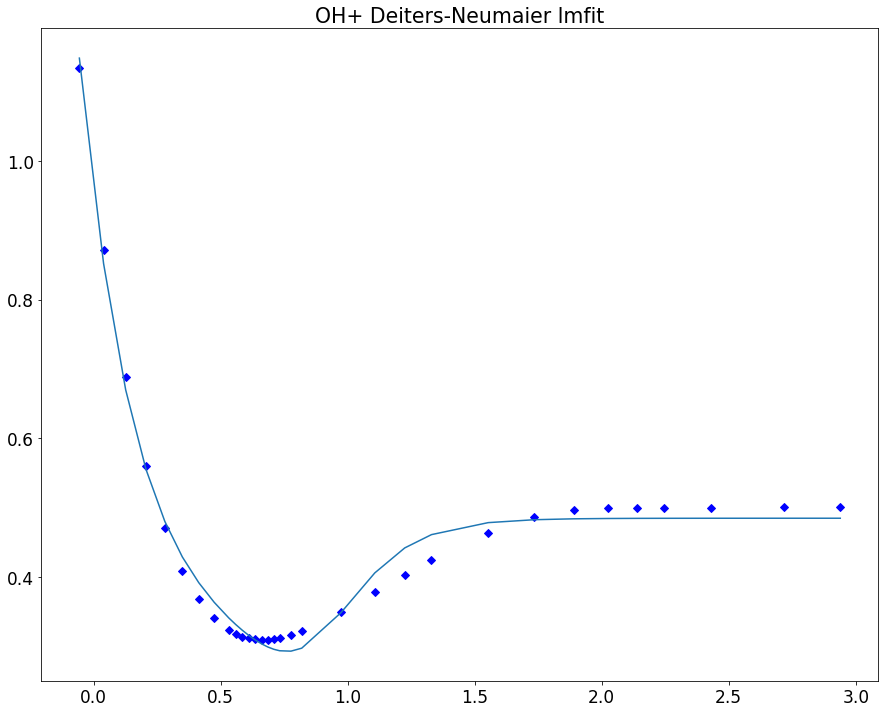

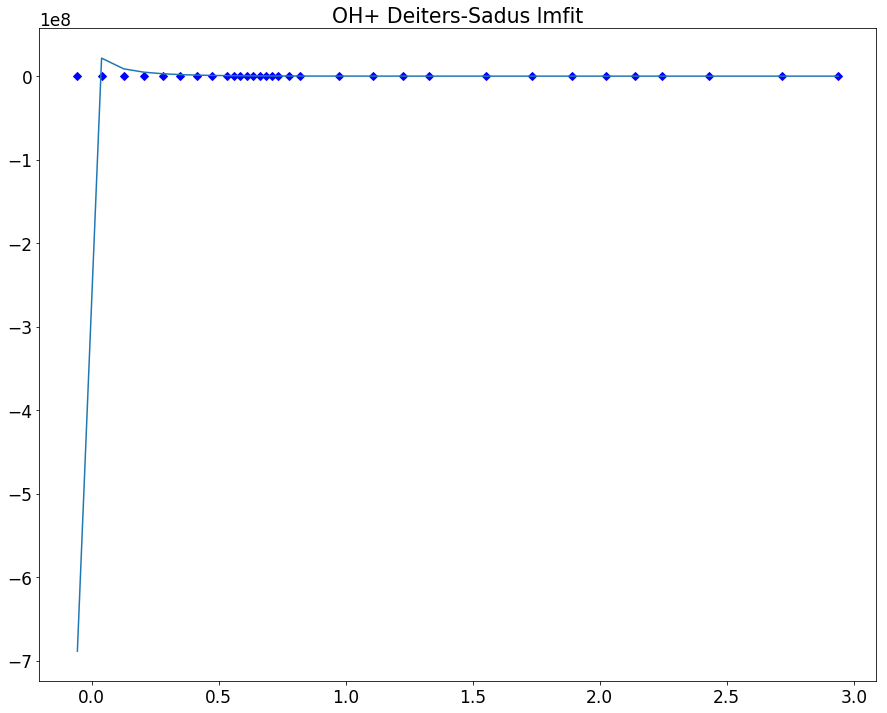

In [14]:
#Deiters-Neumaier:
'''
#from available coeffs (for Argon)
C = [1.639146038e9, 7.075527590e5, 2.726770354e4, 2.503350833] #from table 1 https://pubs-acs-org.uaccess.univie.ac.at/doi/full/10.1021/acs.jced.6b00133#
V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("Deiters-Neumaier OH+, coeffs from table")
'''
##lmfit:
C0 = np.random.uniform(0,1,5) #5 free parameters
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=0, max=np.inf)
out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_dn, V, R), method="leastsq")
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Neumaier lmfit")

#Deiters-Sadus:
## initial points, c[1:5] < 0; c[[0, 5]] > 0, c[6] = 0

C0 = np.random.uniform(-1,-1e-9,8) #8 free parameters 
C_params = Parameters()
#for i, c in enumerate(C0):
#    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

C_params.add(name="c0", value=C0[0], min=1e-9, max=np.inf)
for i in range(1, 5):
    C_params.add(name="c"+str(i), value=C0[i], min=-np.inf, max=-1e-9)
C_params.add(name="c5", value=C0[5], min=1e-9, max=np.inf)
C_params.add(name="c6", value=0, vary=False)
C_params.add(name="c7", value=C0[7], min=-np.inf, max=np.inf)
#C_params.add(name="c8", value=C0[8], min=1e-9, max=np.inf)



out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_ds, V, R), method="leastsq")
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_dn(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Sadus lmfit")

[1.  1.  0.1 0.  0.1 1. ]
[-16.93673305 -15.25557368 -13.12042319 -10.6351705   -8.19432168
  -6.08043975  -4.38111197  -3.07014937  -2.0802592   -1.68309164
  -1.34006118  -1.04387073  -0.78806297  -0.56698945  -0.37575005
  -0.21011877  -0.06646596   0.16688793   0.34414078   0.72891471
   0.87569708   0.93792233   0.96675317   0.99119432   0.9970362
   0.99882117   0.9994699    0.99973815   0.99986069   0.99995327
   0.99999167   0.99999781]
[ 0.94486299  1.03934929  1.13383559  1.22832189  1.32280819  1.41729449
  1.51178079  1.60626709  1.70075339  1.74799654  1.79523969  1.84248284
  1.88972599  1.93696914  1.98421229  2.03145544  2.07869859  2.17318489
  2.26767119  2.64561638  3.02356158  3.40150678  3.77945198  4.72431497
  5.66917797  6.61404096  7.55890395  8.50376695  9.44862994 11.33835593
 15.11780791 18.89725989]
-0.5 2.0


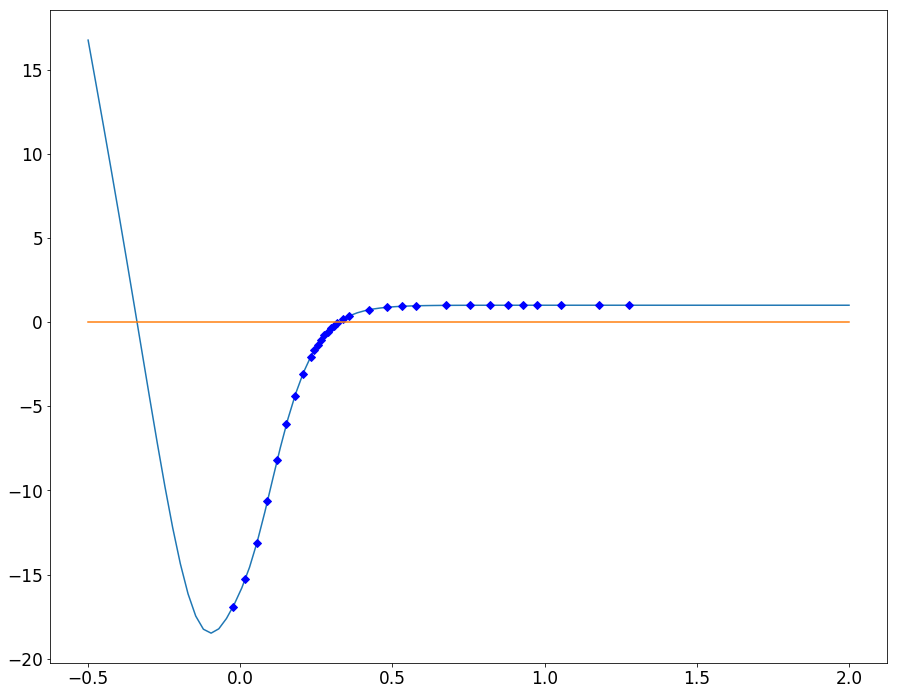

In [304]:
# test print the function:
M = 0.1
C = np.array([1, 1, M, 0, M, 1])
#C = np.zeros(5)
print(C)
ex = np.linspace(-.5, 2, 100)
R_temp = 10**ex
V_temp = f_diatomic_vdw(C, R_temp, 8)
V_pred = f_diatomic_vdw(C, R, 8)

plt.subplots(figsize=(15, 12))
plt.plot(np.log10(R_temp), V_temp)
plt.plot(np.log10(R), V_pred, "bD")
plt.plot([ex[0], ex[-1]], [0,0])
#plt.plot(np.log(R), V_pred)
print(V_pred)
print(R)
print(ex[0], ex[-1])

C after fit [  0.50235353  -1.17188655 -14.77340122  -2.11919494  -0.94912454
   0.15377634  -0.03778822]
RMSE =  0.0013656805061968938


Text(0.5,1,'OH+ 3rd model lmfit')

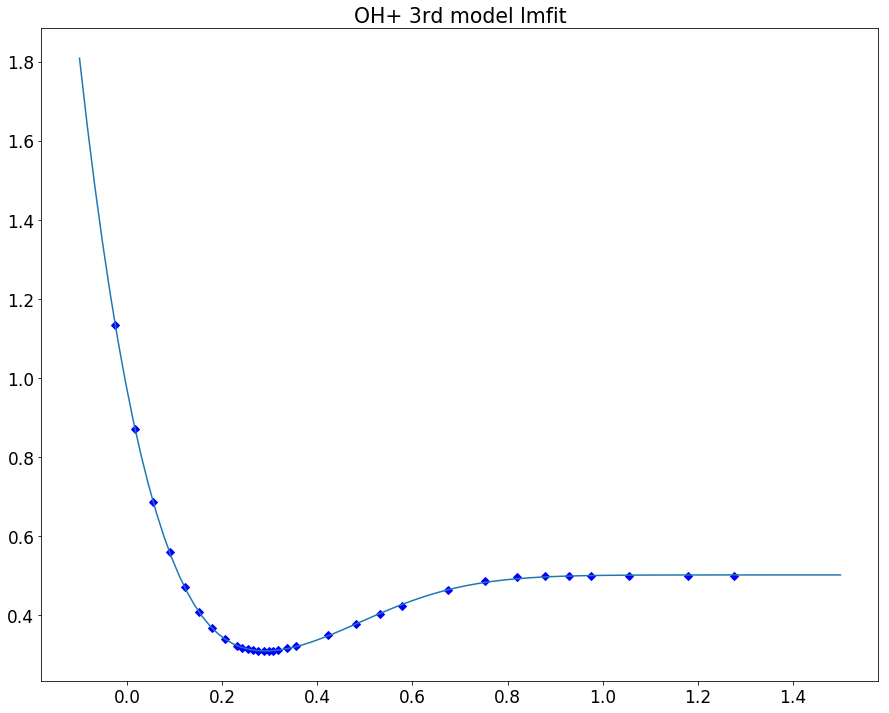

In [15]:
#new proposed model:
'''
C0 = np.zeros(5)
tempC = np.random.uniform(1e-2, 1e9, 2)
C0[0] = tempC[0]; C0[2] = tempC[1]
Z = 8
f_diatomic_vdw(C0, R, Z)
res = least_squares(f_obj_diatomic_pot_res, C0, args=(f_diatomic_vdw, V, R, Z), verbose=1)
print(res.message)
V_pred = f_diatomic_dn(res.x, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ Deiters-Neumaier with fitted coef using Levenberg-Marquadt least squares")
'''
##lmfit:
C0 = np.random.uniform(0, 1, 7) #7 free parameters
#add params:
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_diatomic_vdw, V, R, 8), method="leastsq", max_nfev=int(1e4))
#transform out.params to C array:
C = np.array([out.params[key] for key in out.params])
#C0 -> |C0|, C3->|C3|:
#C[0] = np.abs(C[0])
#C[3] = np.abs(C[3])

print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
#report_fit(out, show_correl=True, modelpars=V)

V_pred = f_diatomic_vdw(C, R, 8)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
ex = np.linspace(-.1, 1.5, 100)
R_temp = 10**ex
V_temp = f_diatomic_vdw(C, R_temp, 8)
plt.plot(np.log10(R), V, "bD")
#plt.plot(np.log10(R), V_pred)
plt.plot(np.log10(R_temp), V_temp)
plt.title("OH+ 3rd model lmfit")

#### Multiple starts for the optimization

In [109]:
##finding the global optimum by multiple starting points, take the lowest RMSE:
M=10
m = int((2*m-2)/3)
#len_C = 3*(m+1) + M #chipr
len_C = 3*M + 1 #must always be 3M+1 parameters for the ansatz
print("params =",len_C)
#rmse, C = multiple_multistart(int(5), int(2), 1e-5, f_diatomic_chipr_ohplus, V, *(R, 8, M, m), len_C=len_C, mode="default")
rmse, C = multiple_multistart(int(20), int(2), 1e-5, f_diatomic_vdw, V, *(R, 8, M), len_C=len_C, mode="default")

print("rmse = ",rmse)
print(C)
'''
V_pred = f_diatomic_vdw(C, R, 8, m)
plt.subplots(figsize=(15, 12))
plt.plot(np.log(R), V, "bD")
plt.plot(np.log(R), V_pred)
plt.title("OH+ 3rd model lmfit")
'''

params = 31
0 th round is done
RMSE =  0.0011093139439811884
1 th round is done
RMSE =  0.0011014186499372232
2 th round is done
RMSE =  0.00018473776039032832
3 th round is done
4 th round is done
RMSE =  6.25676885982276e-06
rmse =  6.25676885982276e-06
[ 5.00455556e-01  5.34124006e+00 -8.11559517e+00  3.50686266e+00
  5.73485780e+00  5.38550535e+00  4.41097521e+00  3.46989504e+00
  2.54917688e+00  1.44857831e+00  4.16262633e-01 -1.34727867e+00
 -3.29082343e+00 -3.50435095e+00 -9.21682025e-01  5.11801963e-01
  1.21219718e-01 -6.75975009e-02  8.98809189e-03 -4.05165200e-04
 -9.44835941e+00  1.08888661e+01 -5.74864030e+00 -3.63409959e+00
  5.66186034e+00 -5.30473723e+00  2.19756590e+00 -6.36428165e-01
  1.15618566e-01 -1.02166824e-02  1.94154435e-04]


'\nV_pred = f_diatomic_vdw(C, R, 8, m)\nplt.subplots(figsize=(15, 12))\nplt.plot(np.log(R), V, "bD")\nplt.plot(np.log(R), V_pred)\nplt.title("OH+ 3rd model lmfit")\n'

In [ ]:
#several obtained data from training for OH+ data for the 3rd ansatz

rmse =  0.7608358031159257
[ 0.45202643 -0.56713766 14.99790643 14.21165152 16.94242195]

rmse =  0.3388745479985727
[ 1.40190265  1.6732669   0.85488082 -1.37075425  0.85787211]

rmse =  0.3044378687788408
[ 1.58502333e+00  1.02774471e+02  6.17834991e-01 -3.31775174e-01
  9.75283009e-02]

rmse =  0.29465895741657055
[ 8.19332849e-01  1.00754909e+02  6.16203290e-01 -3.31951898e-01
  9.81530688e-02]


#m-family pot, with m=2:
rmse =  0.0018350440406569792
[ 5.02893115e-01  2.43195189e+02  3.67590116e+02 -1.74032015e+03
  1.24472977e+00 -3.29342438e-02  5.33987052e-02]

In [32]:
rmse =  0.0018350440406569792
C = np.array([ 5.02893115e-01,  2.43195189e+02,  3.67590116e+02, -1.74032015e+03,
  1.24472977e+00, -3.29342438e-02,  5.33987052e-02])
m=2
V_pred = f_diatomic_vdw(C, R, 8, m)
print("RMSE = ",RMSE(V_pred, V))

RMSE =  0.001835044040685022


C after fit [-1.05134424 -2.22507655]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 32
    # variables        = 2
    chi-square         = 3.78443419
    reduced chi-square = 0.12614781
    Akaike info crit   = -64.3148644
    Bayesian info crit = -61.3833926
[[Variables]]
    c0: -1.05134424 +/- 0.53445594 (50.84%) (init = -9.29927e+08)
    c1: -2.22507655 +/- 0.64636791 (29.05%) (init = -4.031011e+08)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, c1) =  0.948
RMSE =  0.34389470567675695


Text(0.5,1,'OH+ LJ lmfit')

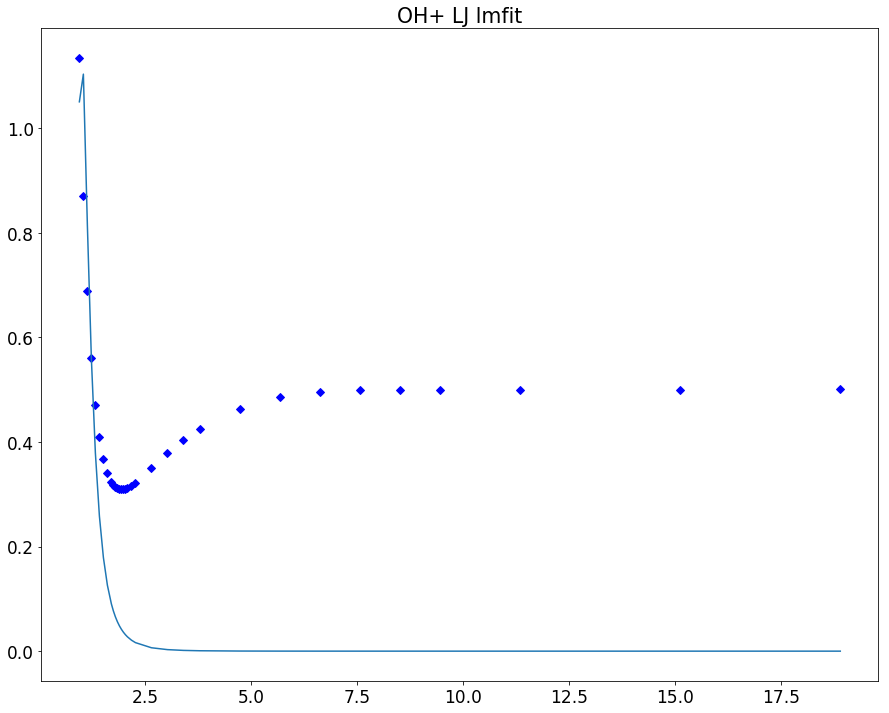

In [221]:
C0 = np.random.uniform(-1e9, 1e9, 2)
C_params = Parameters()
for i, c in enumerate(C0):
    C_params.add(name="c"+str(i), value=c, min=-np.inf, max=np.inf)

out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(f_lj_pot, V, R), method="leastsq")
C = np.array([out.params[key] for key in out.params])
print("C after fit",C)

#fit = f_obj_diatomic_pot_res_lmfit(out.params, F)
report_fit(out, show_correl=True, modelpars=V)

V_pred = f_lj_pot(C, R)
print("RMSE = ",RMSE(V_pred, V))
plt.subplots(figsize=(15, 12))
plt.plot(R, V, "bD")
plt.plot(R, V_pred)
plt.title("OH+ LJ lmfit")

### Model 141021

#### Multiple data tests at once

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


C after fit [  0.6636017    0.38751827 -26.35529515  -2.38827907   6.39510433
  20.76354389   3.4992733    2.67131316  19.00970747  16.08588802
  -6.85902634  12.74758881  -0.17147783  11.47370008   6.83205733
  14.32356195   9.09752304  16.18753132   0.2808033 ]
CHIPR RMSE =  0.0019885582566109244
C after fit [-0.86400645 -1.88600278  0.90744564  0.36128171]
Deiters-Neumaier RMSE =  0.010588309082711977
C after fit [-1.45549563e+00  4.39739089e+00 -7.99506708e+02 -5.15916708e-02
  7.95725030e+02 -2.64881032e+00 -1.15815470e+00]
Deiters-Sadus RMSE =  0.006996300750155395
C after fit [ 0.02468145  0.31216736  0.95290725 -1.77367869  0.03852885]
3rd ansatz RMSE =  0.3967557594802528


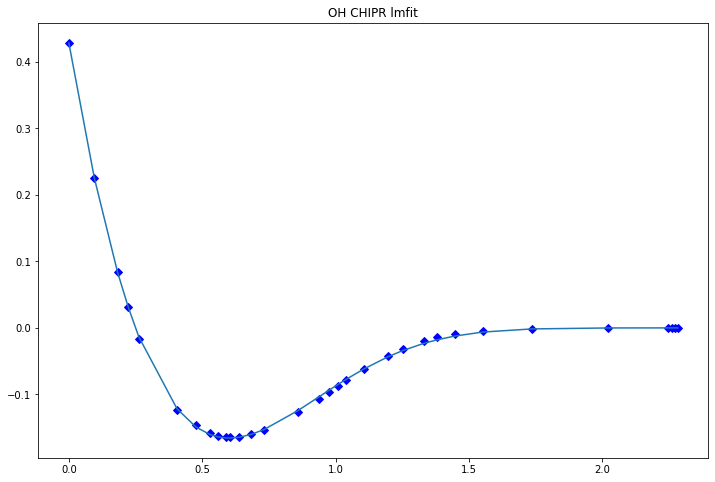

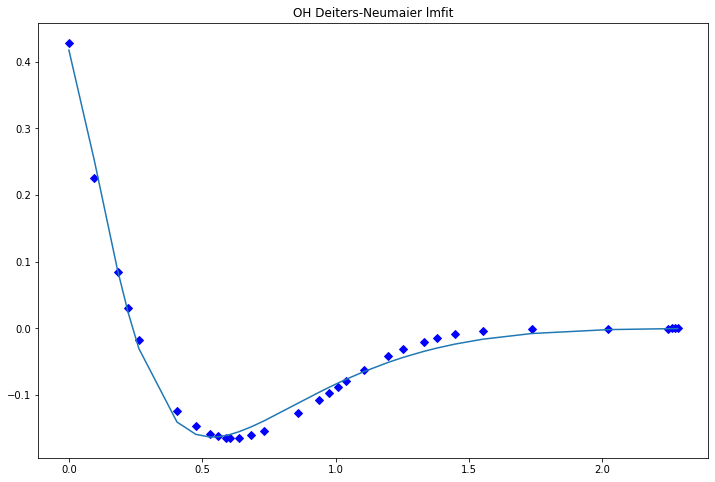

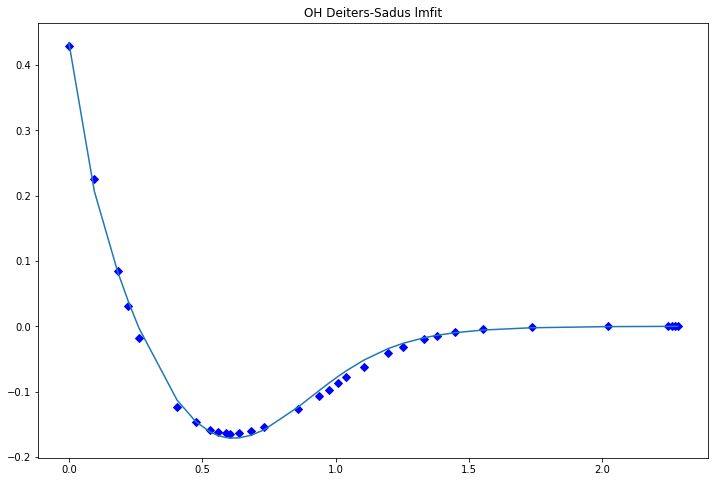

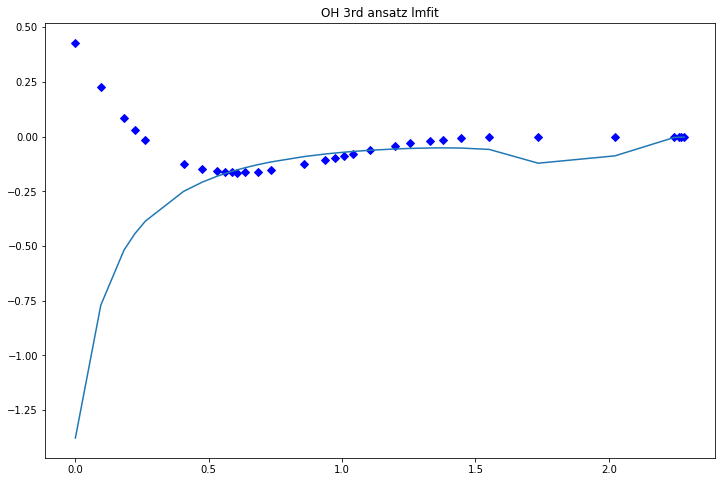

In [100]:
#test available models on each data (using lmfit now):
#OH $X^2\Pi$ Nemukhin and Grigorenko(1997) 32

'''
mols = ["OH", "O2+", "O2", "H2", "H2+"]
states = ["$X^2\Pi$", "$X^2\Pi_g$", "$^3\Sigma_g^-$", "ground", "$X^2\Sigma_g^+ 1s \sigma_g$"]
authors = ["Nemukhin and Grigorenko(1997)", "Xavier(2018)", "Bytautas(2010)", "H2 Kolos(1965)", "Sharp(1971)"]
for k in range(len(mols)):
    #queries:
    mol = mols[k]; state = states[k]; author = authors[k]
    idx = query_many_vars_indices([mol, state, author], ["mol","state","author"], list_data)
    R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]
'''

mol = "OH"
idx = query_many_vars_indices([mol,"$X^2\Pi$","Nemukhin and Grigorenko(1997)"], ["mol","state","author"], list_data)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                          np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
#optimize:
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

[35, 36, 37]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [-4.08936932e-01  1.93136672e-02 -4.34735155e-02  1.32795736e-01
 -1.64454577e-01  4.35953428e+00  3.69377061e-01  1.09525728e+00
 -1.89119470e+00  1.69549689e+00  1.64564411e+00  1.04481758e+00
 -8.54875319e-01  9.20142510e-01  7.72990090e-01  2.10240820e+00
 -1.45354063e-03  1.15823238e+00  4.91680204e+00]
CHIPR RMSE =  0.000348618372506354
C after fit [ 0.93047244 -0.65198518 -7.96545951 -0.03908842]
Deiters-Neumaier RMSE =  0.2782822804644427
C after fit [ 1.68792213e+01  1.63412589e+00 -6.57671353e+01  1.21864723e+00
 -2.05849304e+02 -4.46872411e+01 -9.95192912e-03]
Deiters-Sadus RMSE =  0.3089238344811664
C after fit [  4.8188279    3.09265446   7.36172655  13.30504416 -88.85338835]
3rd ansatz RMSE =  0.43257627899128076


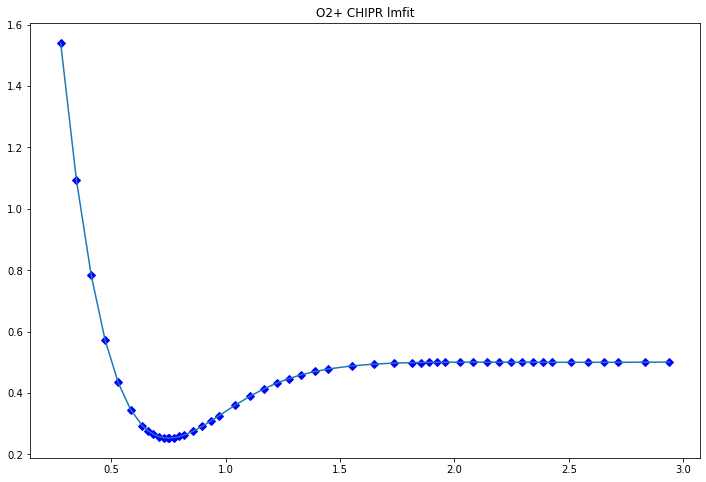

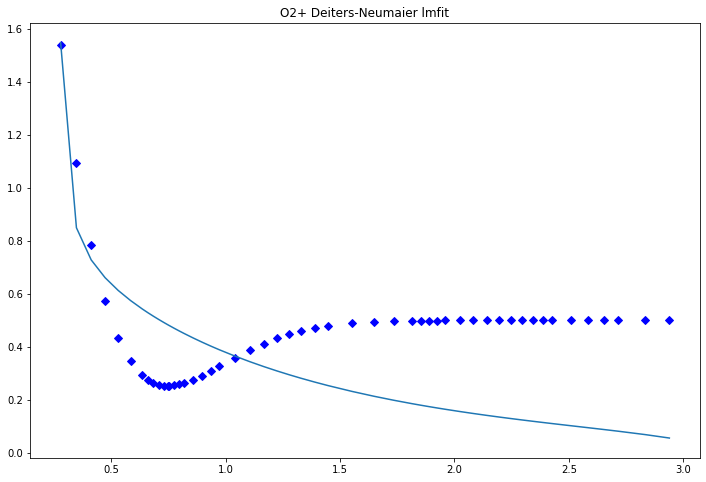

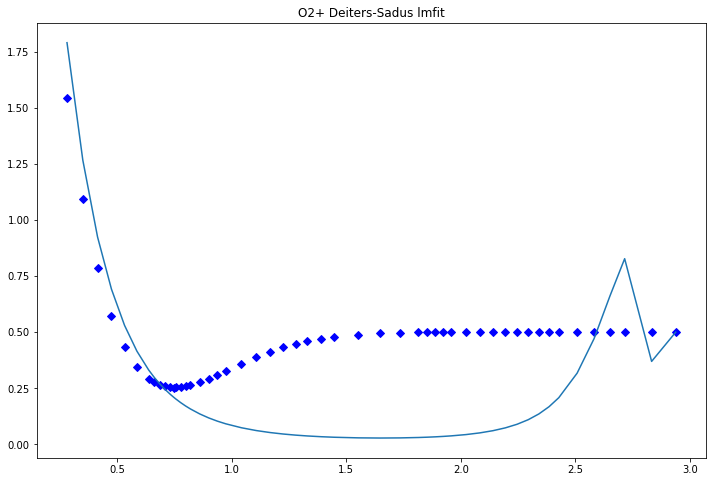

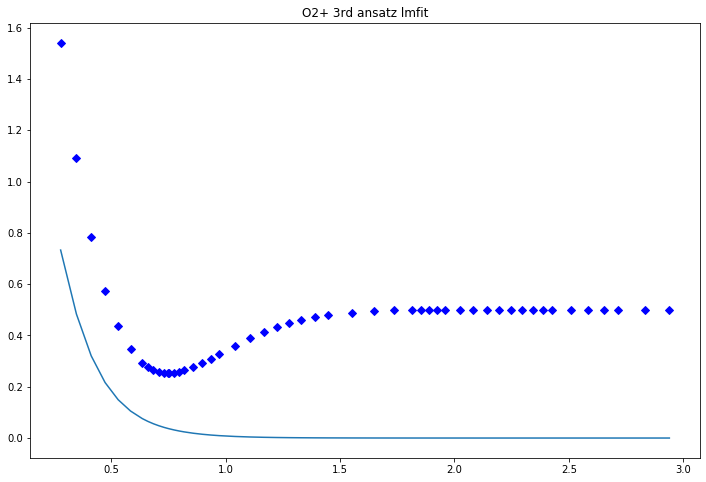

In [101]:
#O2+ $X^2\Pi_g$ Xavier(2018) 51
mol = "O2+"
idx = query_many_vars_indices([mol,"$X^2\Pi_g$","Xavier(2018)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]

##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)
    
    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

[17]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [-1.72454016  1.60887705  1.07524731 -2.07245441  5.44918873  0.63060324
 -1.09559607  0.56052398 -0.12910523  0.01324929  1.51497948 -0.89238472
  0.76698878  0.19709672  1.42343164  0.52877561  0.31603624  2.74265084
  1.14219318]
CHIPR RMSE =  0.00096766880526363
C after fit [ 2.61837712e+03  2.06542100e+05 -1.33389666e+02  4.95274372e-01]
Deiters-Neumaier RMSE =  0.007602799409312086
C after fit [-0.50719184 -0.37253752 -0.99191575 -0.9765786   0.27970902 -1.25640081
 -0.06093759]
Deiters-Sadus RMSE =  0.12174280104408788
C after fit [ 0.32189562  0.08826392  0.08144192  0.78858093 -0.00156081]
3rd ansatz RMSE =  0.10296348258343929


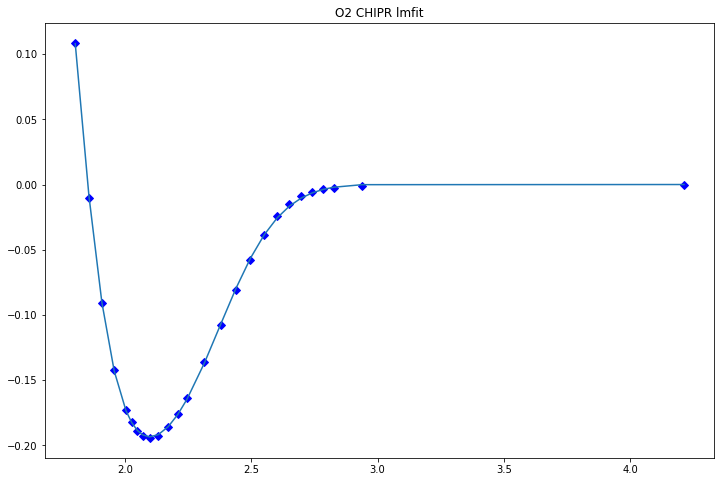

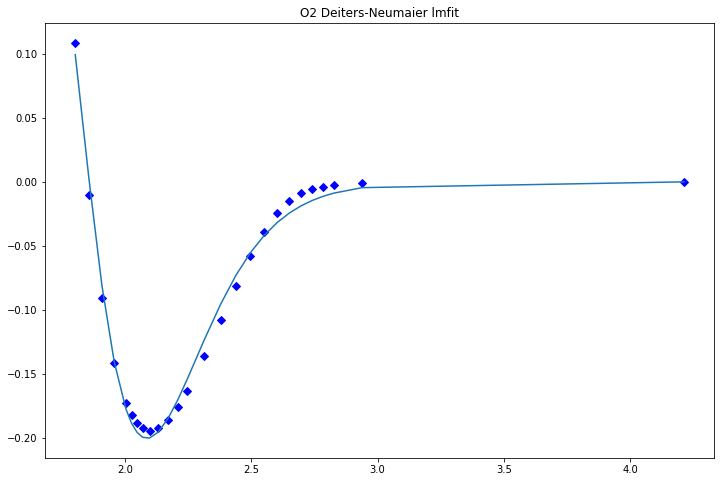

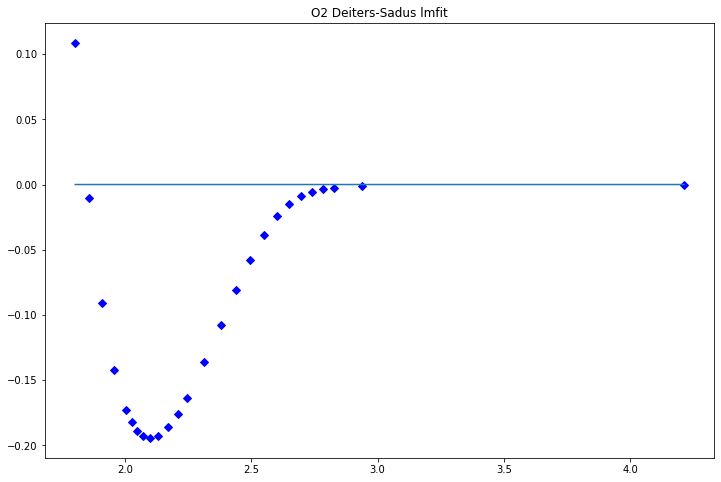

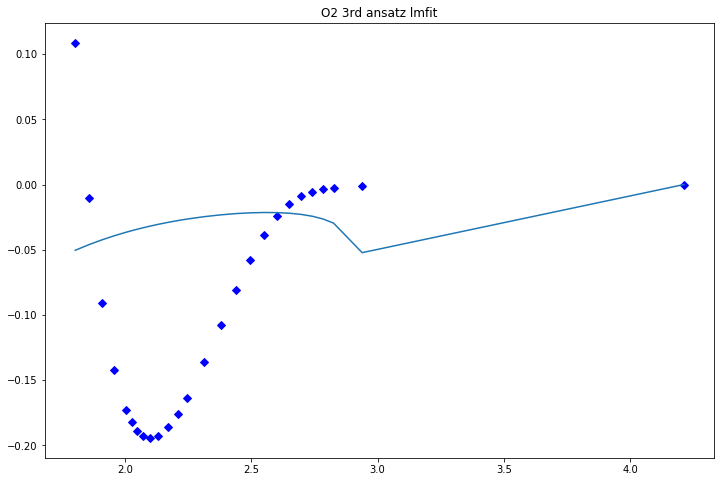

In [102]:
#O2 $^3\Sigma_g^-$ Bytautas(2010) 26
mol = "O2"
idx = query_many_vars_indices([mol,"$^3\Sigma_g^-$","Bytautas(2010)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]

##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")


[20]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [ 0.7470348   1.91457572 -0.38002268  0.44483806  0.00799644 -0.08843682
 -1.6997957  -3.5817279   2.05027925  1.63592121  0.47668814  0.3902616
  0.24042801  2.17051513  2.38855204  2.73202377  5.45503124  1.63228227
  0.45253894]
CHIPR RMSE =  0.00013907860272050865
C after fit [  1.69866893  17.9586175  185.87253493   2.86247496]
Deiters-Neumaier RMSE =  0.019023479533293766
C after fit [ 9.17901584e-01  2.01163322e+00  5.56397462e+01 -2.25459822e-02
 -5.90632592e+01  9.84255579e-02 -4.15946999e-01]
Deiters-Sadus RMSE =  0.0014916684664609402
C after fit [ 1.53678657e-05  6.85846266e-04  2.94014835e+00 -1.31516939e-02
  1.37198422e-01]
3rd ansatz RMSE =  0.13563202996872506


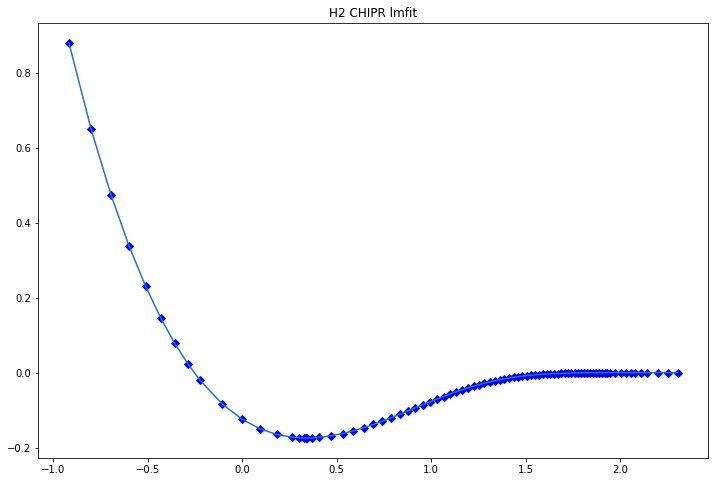

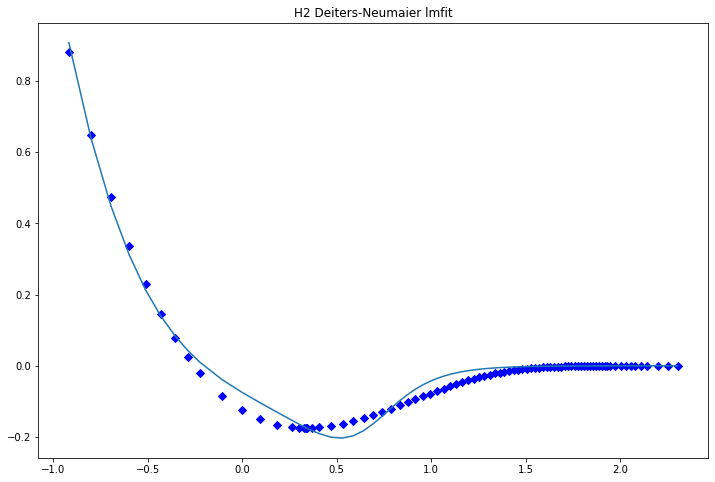

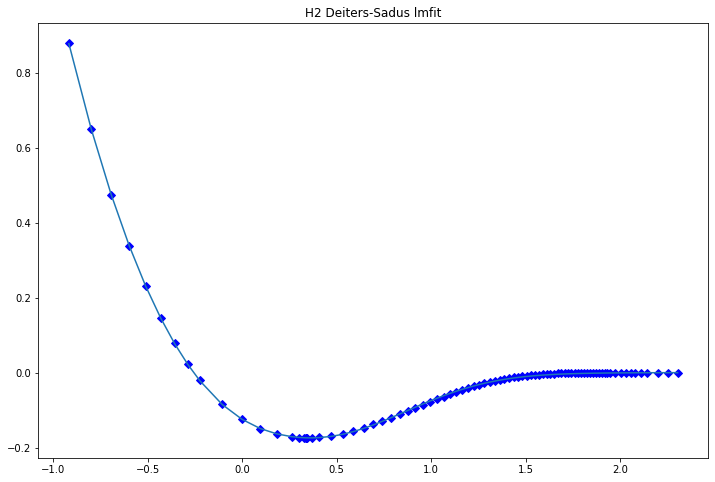

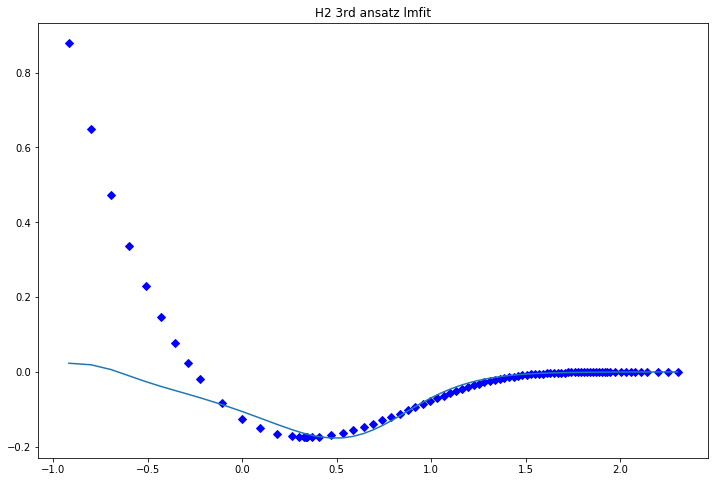

In [107]:
#H2 ground H2 Kolos(1965) 87
mol = "H2"
idx = query_many_vars_indices([mol,"ground","H2 Kolos(1965)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"]; V = list_data[idx[0]]["V"]

##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    #special treatment for 3rd ansatz, C0->|C0|, C2->|C2|:
    if i==3:
        C[0] = np.abs(C[0]); C[2] = np.abs(C[2])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

[28]
[ 0.25001075  0.5000215   0.75003224  1.00004299  1.25005374  1.50006449
  1.74988627  1.99989701  2.24990776  2.49991851  2.74992926  2.99994001
  3.4999615   3.999983    4.5000045   4.99983702  5.49985852  5.99988001
  6.49990151  6.99992301  7.99977703  8.99982002  9.99986301 11.99976003
 13.99965704 15.99974303 17.99964004 19.99953706]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


C after fit [-0.04458781  0.90135017  0.55435426 -0.58191494 -0.81131965  0.648264
 -0.77791062 -0.26324257 -0.11221761 -0.02561277  0.0769068   3.12295619
  0.68313179  3.46974508  1.67406674  0.2833368  -0.08941719  0.25498657
  0.0690522 ]
CHIPR RMSE =  0.00039868909605815083
C after fit [ 0.82047973  0.52863891  0.51402926 -0.03901942]
Deiters-Neumaier RMSE =  0.2755323193200035
C after fit [ 9.43097028e+03  1.90067119e+02  2.48230814e+02 -4.05845731e-03
 -2.46557328e+02 -4.10832463e-02 -9.20535298e+02]
Deiters-Sadus RMSE =  0.39107723930214616
C after fit [ 1.25462782e-03  1.35086776e-02 -1.25800471e+03  5.14651336e+03
 -4.67461724e+02]
3rd ansatz RMSE =  0.837677181748727


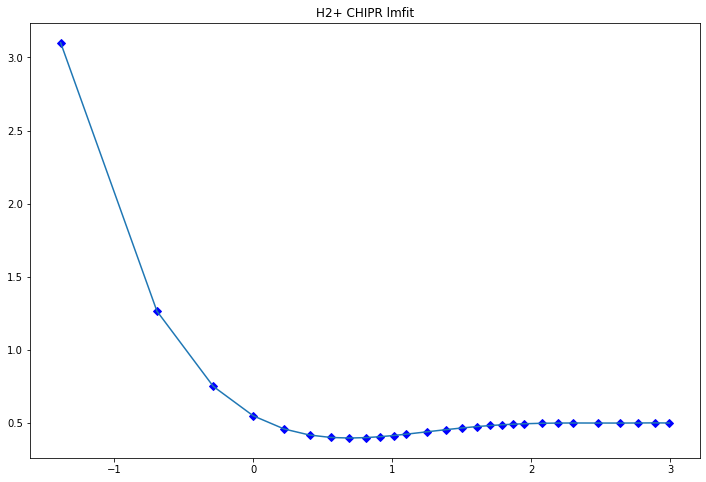

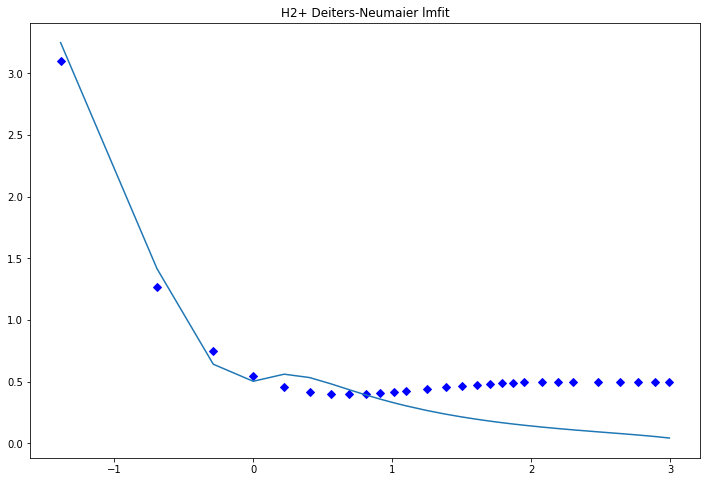

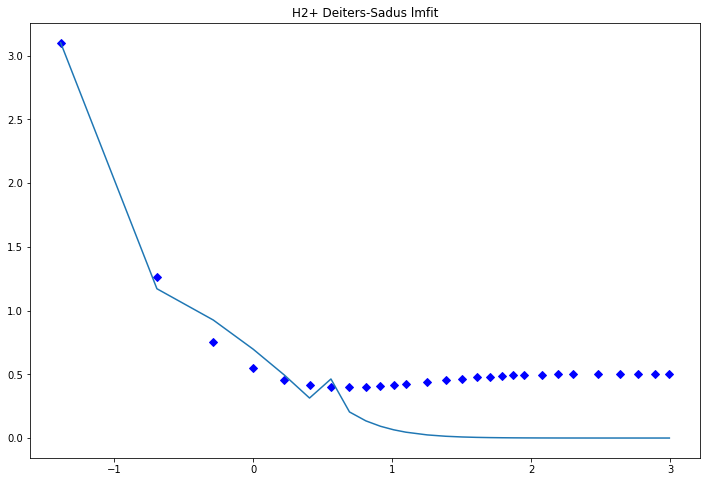

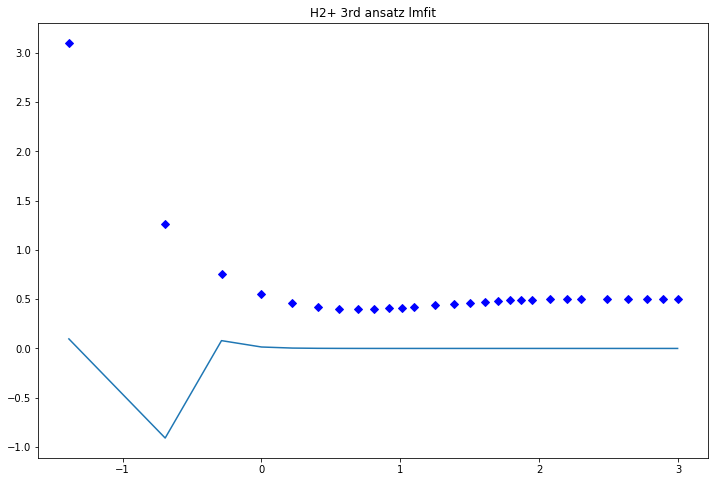

In [116]:
#H2+ $X^2\Sigma_g^+ 1s \sigma_g$ Sharp(1971) 29
mol = "H2+"
idx = query_many_vars_indices([mol,"$X^2\Sigma_g^+ 1s \sigma_g$","Sharp(1971)"], ["mol","state","author"], list_data)
print(idx)
R = list_data[idx[0]]["R"][:len(list_data[idx[0]]["R"])-1]; V = list_data[idx[0]]["V"][:len(list_data[idx[0]]["R"])-1] #slice last due to infinite
print(R)
##refit using lmfit:
C0_arrays = np.array([np.random.uniform(0, 1, 19)+1e-9, np.random.uniform(0,1,4), 
                      np.random.uniform(-1,-1e-9,7), np.random.uniform(-1, 1, 5)])
Fs = [f_diatomic_chipr_ohplus, f_diatomic_dn, f_diatomic_ds, f_diatomic_vdw]
F_names = ["CHIPR", "Deiters-Neumaier", "Deiters-Sadus", "3rd ansatz"]
args_array = [[R], [R], [R], [R, 8]]
for i in range(len(Fs)):
    C0 = C0_arrays[i]; F = Fs[i]; F_name = F_names[i]; arg = args_array[i]
    C_params = Parameters()
    for j, c in enumerate(C0):
        C_params.add(name="c"+str(j), value=c, min=-np.inf, max=np.inf)
    out = minimize(f_obj_diatomic_pot_res_lmfit, C_params, args=(F, V, *arg), method='bfgs')
    #transform out.params to C array:
    C = np.array([out.params[key] for key in out.params])
    print("C after fit",C)

    V_pred = F(C, R, *arg)
    print(F_name, "RMSE = ",RMSE(V_pred, V))
    plt.subplots(figsize=(12, 8))
    plt.plot(np.log(R), V, "bD")
    plt.plot(np.log(R), V_pred)
    plt.title(mol+" "+F_name+" lmfit")

In [14]:
#SNOBFIT example
from skquant.opt import minimize

 # some interesting objective function to minimize
def objective_function(x):
    fv = np.inner(x, x)
    fv *= 1 + 0.1*np.sin(10*(x[0]+x[1]))
    return np.random.normal(fv, 0.01)

# create a numpy array of bounds, one (low, high) for each parameter
bounds = np.array([[-1, 1], [-1, 1]], dtype=float)

# budget (number of calls, assuming 1 count per call)
budget = 40

# initial values for all parameters
x0 = np.array([0.5, 0.5])

# method can be ImFil, SnobFit, Orbit, NOMAD, or Bobyqa
result, history = \
    minimize(objective_function, x0, bounds, budget, method='SnobFit')

print(result, history)

Optimal value: -0.00488087, at parameters: [ 0.00704 -0.00702] [[ 4.75577306e-01  5.00000000e-01  5.00000000e-01]
 [ 1.79396240e+00 -9.92560000e-01 -9.56420000e-01]
 [ 1.75856896e+00  9.37240000e-01 -9.94180000e-01]
 [ 1.66987607e+00 -9.96200000e-01  9.09340000e-01]
 [ 2.24973792e-01 -6.78000000e-03 -4.61920000e-01]
 [ 6.66081890e-01 -8.37260000e-01 -3.78400000e-02]
 [ 1.12167798e+00 -1.60740000e-01  9.98200000e-01]
 [ 1.07475569e+00  9.76480000e-01 -1.76960000e-01]
 [ 8.97612888e-02 -1.88160000e-01  2.35260000e-01]
 [ 2.10983090e+00  9.80020000e-01  9.97020000e-01]
 [ 1.00833329e+00 -3.50720000e-01 -9.87260000e-01]
 [-4.88086958e-03  7.04000000e-03 -7.02000000e-03]
 [ 8.27887094e-02  2.55860000e-01  1.07660000e-01]
 [ 2.03336312e-01 -4.45180000e-01  3.98200000e-02]
 [ 2.81050929e-01  2.31560000e-01 -4.89300000e-01]
 [ 8.97710435e-02 -3.14000000e-02  2.68140000e-01]
 [ 2.10714998e-01  2.92200000e-02  4.91880000e-01]
 [ 6.37884227e-01  6.11540000e-01 -4.43060000e-01]
 [ 1.61110054e-01 -

### Models 191021

#### CHIPR vs Diatomic ansatz performance evaluations (RMSE and time) for the (union of (ideally, currently only pick one)) OH+ dataset

In [ ]:
'''
performance evaluation per dataset contains:
"mol": molecule data name
"F": the functions list
"F_names": the name of the functions
"rmse": list of rmse 
"time": list of time evaluation,
"C_best": list of 1D array of best coefficients found,
"M": polynomial degree
"num_params": the number of parameters

by varying the free parameters:
CHIPR: 3(m+1) + M 
diatomic ansatz: 3M+1
M is common parameter, hence it is used as the reference,
m = 2M-2/3, where 2M-2%3 = 0
'''
Fs = [f_diatomic_vdw, f_diatomic_chipr_ohplus]
F_names = ["ansatz", "CHIPR"]

loop = int(1e4); n = 20; # # of loops per run and evaluation runs
restarts = int(20); powers = int(5); # number of optimization restarts and powers for random number generations
delta = 1e-5 #error tolerance to stop iterations

#physical params:
Z = 8

data = {}
data["num_params"] = []
data["eval_loop"] = loop; data["eval_run"] = n;
data["opt_restart"] = restarts; data["opt_power"] = powers; data["opt_delta"] = delta
data["chipr_t"] = []; data["chipr_acc"] = []; data["chipr_C"] = []
data["ansatz_t"] = []; data["ansatz_acc"] = []; data["ansatz_C"] = []
data["degree"] = []

max_deg = 30 #maximum polynomial degree
init_time = time.time() #timer

for M in range(4, max_deg):
    if (2*M - 2)%3 == 0: # must satisfy this
        m = int((2*M - 2)/3)
        ansatz_par = 3*M+1
        #chipr_par = 3*(m+1)+M;
        print("===========================")
        print("M = ",M, ", m (chipr) =",m)
        print("parameters = ",ansatz_par)
        
        #Time evaluation:
        print(">>> Time evaluation:")
        args = [(R,Z,M), (R,Z,M,m)] 
        times_array = np.zeros(len(Fs))
        len_C = ansatz_par #coef length, min(len) = 3M+1
        for i in range(n):
            times_array += np.array(evaluate_efficiency(Fs, loop, args, len_C))
        mean_t = times_array/n
        print("evaluation on",loop,"runs")
        print("functions",F_names)
        print("running times averaged over",n,"runs",mean_t)
        
        #Accuracy evaluation:
        print(">>> Accuracy evaluation:")
        rmses = []; Cs = []
        for i, f in enumerate(Fs):
            rmse, C = multiple_multistart(restarts, powers, delta, f, V, *args[i], len_C=len_C, mode="default")
            rmses.append(rmse)
            Cs.append(C)
            print("rmse = ",rmse)
            
        #append to data:
        data["num_params"].append(len_C); data["degree"].append(M)
        data["ansatz_t"].append(mean_t[0]); data["chipr_t"].append(mean_t[1])
        data["ansatz_acc"].append(rmses[0]); data["chipr_acc"].append(rmses[1])
        data["ansatz_C"].append(Cs[0]); data["chipr_C"].append(Cs[1])



end_time = time.time() #timer
elapsed = end_time-init_time
data["simulation_time"] = elapsed
print("elapsed time =",elapsed,"s")
print(data)
#write to pandas, then to file:
df = pd.DataFrame.from_dict(data)
df.to_pickle("result/performance_"+datetime.datetime.now().strftime('%d%m%Y')+".pkl")

In [25]:
#display the table result:
data = pd.read_pickle("result/performance_22102021.pkl")
'''
data["simulation_time"] = 2429.074455499649
data["eval_loop"] = loop; data["eval_run"] = n;
data.to_pickle("result/performance_19102021_2.pkl")
print(data)
'''
display = data[['num_params', 'ansatz_acc', 'chipr_acc','ansatz_t', 'chipr_t', ]]
display

,num_params,ansatz_acc,chipr_acc,ansatz_t,chipr_t
0,13,0.000256,0.000230,0.410673,0.456578
1,22,0.000162,0.000209,0.591657,0.784567
2,31,0.000039,0.000195,0.781771,1.118280
3,40,0.000054,0.000235,0.951766,1.416891
4,49,0.000029,0.000090,1.134819,1.742435
5,58,0.000072,0.000152,1.316050,2.063720
6,67,0.000137,0.000194,1.505820,2.398215
7,76,0.000147,0.000178,1.688335,2.716334
8,85,0.000070,0.000215,1.872056,3.033693


==== Optimization stats ====
data:  OH+ $X^3\Sigma^-$ Xavier(2018) 32 data points
optimization restarts =  20
optimization power =  1
delta threshold =  1e-05
evaluation loops =  10000
evaluation runs =  20
elapsed time =  2429.074455499649 s


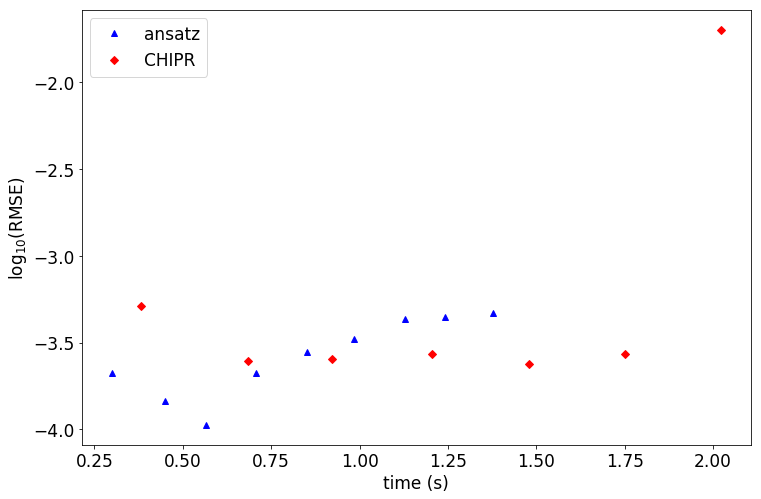

In [64]:
## plot of the table (finding which model is the best)
plt.subplots(figsize=(12, 8))
plt.plot(data["ansatz_t"], np.log10(data["ansatz_acc"]), 'b^')
plt.plot(data["chipr_t"], np.log10(data["chipr_acc"]), 'rD')
plt.xlabel("time (s)"); plt.ylabel("log$_{10}$(RMSE)")
plt.legend(["ansatz", "CHIPR"])
print("==== Optimization stats ====")
print("data: ", list_data[qidxs[idx]]["mol"], list_data[qidxs[idx]]["state"], list_data[qidxs[idx]]["author"],
      len(R),"data points")
print("optimization restarts = ",data["opt_restart"][0])
print("optimization power = ", data["opt_power"][0])
print("delta threshold = ", data["opt_delta"][0])
print("evaluation loops = ",data["eval_loop"][0])
print("evaluation runs = ",data["eval_run"][0])
print("elapsed time = ", data["simulation_time"][0], "s")

In [8]:
#Notes:
# - plot the data error using unified model on each dataset of a molecule

#union the data of OH+ mol:
mol = "OH+"
qidxs = query_one_var_indices(mol, "mol", list_data)
print(qidxs)
#test on idx 1, train on idx 4:
#print(list_data[qidxs])
idx = [0, 4] #manually pick the data
R_list = []; V_list = []
for i in idx:
    R = list_data[qidxs[i]]["R"]
    V = list_data[qidxs[i]]["V"]
    R_list.append(R); V_list.append(V)
    
R_list = np.array(R_list); V_list = np.array(V_list)
R = np.concatenate(R_list)
V = np.concatenate(V_list)

[26, 27, 32, 33, 34]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
#pick one model from the plot above: the best one for OH+ is parameters = 31 (M = 10, m=6) for both ansatz and CHIPR:
#re-train using the unified data
Fs = [f_diatomic_vdw, f_diatomic_chipr_ohplus]
F_names = ["ansatz", "CHIPR"]
Z = 8
M = 7; m = 4; len_C = 3*M + 1
restarts = 5; powers = 1; delta = 1e-5
args = [(R,Z,M), (R,Z,M,m)]
rmses = []; Cs = []
for i, f in enumerate(Fs):
    rmse, C = multiple_multistart(restarts, powers, delta, f, V, *args[i], len_C=len_C, mode="default")
    rmses.append(rmse); Cs.append(C)
    print(F_names[i], "rmse = ",rmse)
print(rmses)
print(Cs)

0 th round is done
RMSE =  0.0032640955598382732
1 th round is done
RMSE =  0.0018187511870501405
2 th round is done
RMSE =  0.0018088570283423524
3 th round is done
4 th round is done
RMSE =  0.0017743046888059597
ansatz rmse =  0.0017743046888059597
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: overflow encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


0 th round is done
RMSE =  0.0018264722919174494
1 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


2 th round is done
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C
ValueError!!, resetting C


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in add
C:\Users\beryl\Anaconda3\lib\site-packages\lmfit\minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
C:\Users\beryl\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670

3 th round is done
ValueError!!, resetting C
ValueError!!, resetting C


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: divide by zero encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: overflow encountered in power
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in multiply


4 th round is done
RMSE =  0.001688864584906515
CHIPR rmse =  0.001688864584906515
[0.0017743046888059597, 0.001688864584906515]
[array([ 0.50129172,  5.86860782,  1.50982238,  1.62782368,  0.61784673,
        0.59927463,  2.29974157,  0.63934647,  0.26757982,  0.48510872,
        1.03424444,  0.32452472, -0.84290242, -4.40283267, -5.54025386,
       -0.35331244,  2.28726333, -0.40401587, -0.99533418, -0.85029783,
        0.28323452, -0.05631612]), array([ 1.55238312, -0.44761683, -0.91014387, -0.13547141,  0.9291675 ,
       -0.01369507, -2.36665163, -0.24551581,  0.20880135,  1.96400081,
        0.20929203, -0.34040055,  1.59895494, -0.73736635, -0.68254721,
       -1.24699422,  0.88362071, -0.55544151,  0.57624642,  1.16801502,
       -0.02818624, -1.2238554 ])]


Text(0.5, 1.0, 'Error plot of the model trained on unified OH$^+$ data')

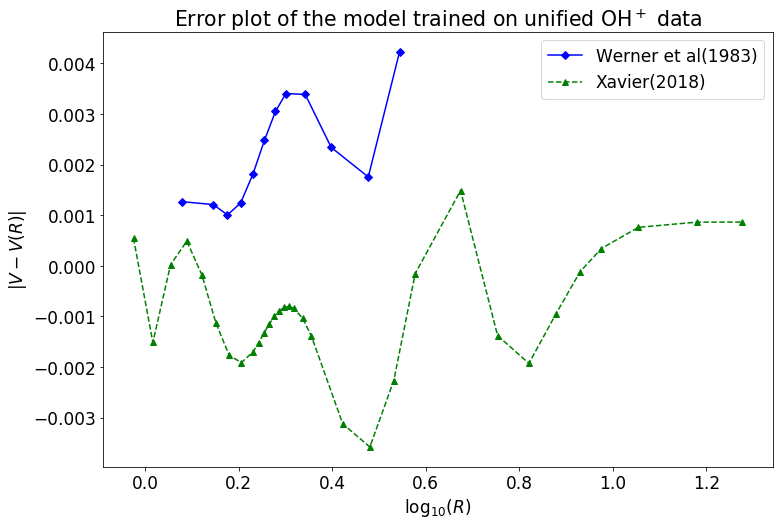

In [14]:
#predict using the unified model
V_preds = []
errors = []
for i in range(len(V_list)):
    V_pred = f_diatomic_vdw(Cs[0], R_list[i], Z, M)
    err = V_pred - V_list[i]
    V_preds.append(V_pred) #using the ansatz
    errors.append(err)

plt.subplots(figsize=(12, 8))
legends = []
shapes = ["-bD","--g^"]
for i in range(len(Cs)):
    plt.plot(np.log10(R_list[i]), errors[i], shapes[i])
    data = list_data[qidxs[idx[i]]]
    legend = data["author"]
    legends.append(legend)
plt.xlabel("log$_{10}(R)$")
plt.ylabel("$|V-V(R)|$")

plt.legend(legends)
plt.title("Error plot of the model trained on unified OH$^+$ data")

### Snobfit exp

In [17]:
from skquant.opt import minimize

# some interesting objective function to minimize
def objective_function(x):
    fv = np.inner(x, x)
    fv *= 1 + 0.1*np.sin(10*(x[0]+x[1]))
    return np.random.normal(fv, 0.01)

# create a numpy array of bounds, one (low, high) for each parameter
bounds = np.array([[-1, 1], [-1, 1]], dtype=float)

# budget (number of calls, assuming 1 count per call)
budget = 40

# initial values for all parameters
x0 = np.array([0.5, 0.5])

# method can be ImFil, SnobFit, Orbit, NOMAD, or Bobyqa
result, history = \
    minimize(objective_function, x0, bounds, budget, method='snobfit')

print(result)

Optimal value: -0.00539033, at parameters: [-0.0153   0.00658]


### Model 120122 - Bonding feature experiments, 8.1-8.6 of Ulrik

#### Utilities

In [137]:
# transform distance vectors to distance matrices:
def distance_vec_to_mat(R, n_atom):
    '''
    returns distance matrix D_{ij}, symmetric with D_{ii} = 0 forall i
    params:
        - R = vector of distances (R_12, R_13, R_23, ...)
        - n_atom = number of atoms in the molecule
    '''
    upper_idxes = np.triu_indices(n_atom, 1) # get the 
    dist_mat = np.zeros((n_atom, n_atom))
    dist_mat[upper_idxes] = R
    dist_mat = dist_mat + dist_mat.T # no need to consider diagonals because theyre always 0
    return dist_mat

# transform distance matrix into coordinate matrix
def distance_to_coord(dist_vec, N, verbose=False):
    '''
    from https://math.stackexchange.com/questions/156161/finding-the-coordinates-of-points-from-distance-matrix
    convert distance vector r_{ij} to coordinate matrix X := [X_0, X_1, X_2], each element is one point (row wise).
    params: 
        - dist_mat = distance matrix, symmetric with 0 diagonals
    '''
    dist_square = dist_vec**2 #q_{ik}:=r_{ik}^2
    dist_square = distance_vec_to_mat(dist_square, N) # D_{ij} matrix from r_{ij}
    M_mat = np.zeros(dist_square.shape)
    #dist_square = dist_mat**2 # D^2
    vec_sum = np.sum(dist_square, axis = 0) # since it's symmetric, sums for row = col
    M_submat = M_mat[1:, 1:] # submatrix excluding 0s in the first column and row
    upper_idxes = np.triu_indices(M_submat.shape[0], 1)
    row = upper_idxes[0]; col = upper_idxes[1] # upper triangular indexes of the submatrix
    row_actual = row+1; col_actual = col+1 # corresponding (row, col) index matrix of the actual matrix
    for idx in range(row.shape[0]): # fill the off diagonals:
        i = row[idx]; j = col[idx];
        i_actual = row_actual[idx]; j_actual = col_actual[idx]
        M_submat[i][j] = (dist_square[0][j_actual] + dist_square[i_actual][0] - dist_square[i_actual][j_actual])/2
    M_submat = M_submat + M_submat.T
    #print(M_submat)
    # fill the diagonals:
    diag = np.diag_indices(M_submat.shape[0])
    M_submat[diag] = dist_square[0][1:] # M'_i-1i-1 := M_ii = D_1i^2
    # return submat to original:
    M_mat[1:, 1:] = M_submat
    if verbose:
        print("M", M_mat)
    # eigendecomposition:
    eigvals, eigvecs = np.linalg.eigh(M_mat) # symmetric matrix eigendecomposition, uses (eigh)ermitian
    #print(eigvecs @ np.diag(eigvals) @ eigvecs.T) # M = Q*lambda*Q^t
    # replace any very small |x| s.t. x<0 \in R, with 0, if |x|<delta:
    delta = -1e-4 # intuitive near 0 threshold
    eigvals[np.where((eigvals > delta) & (eigvals < 0))] = 0
    if verbose:
        print("eigval =",eigvals)
        print("eigvec =",eigvecs)
    X = eigvecs @ np.diag(np.sqrt(eigvals)) # coordinate matrix, each coordinate = X[i]
    return X

def distance_to_coord_v2(dist_vec, N, verbose=False):
    '''
    convert distance vector r_{ij} to coordinate matrix X := [X_0, X_1, X_2], each element is one point (row wise).
    params: 
        - dist_vec = distance vector, (d_1, d_2, ... )
        - N = number of points, scalar
    '''
    q = dist_vec**2 #q_{ik}:=r_{ik}^2
    Q = distance_vec_to_mat(q, N) # convert to distance matrix
    #print("Q", Q)
    gamma_i = np.sum(Q, axis=1)/N # \gamma_i:=\frac{1}{N}\sum_k q_{ik}:
    #print("gamma_i", gamma_i)
    gamma = np.sum(gamma_i)/(2*N) # \gamma:=\frac{1}{2N}\sum_i \gamma_i
    #print("gamma", gamma)
    G_diag = gamma_i - gamma # G_{ii}=\gamma_i-\gamma
    #print("G_diag", G_diag)
    G = np.diag(G_diag) # G_{ii}=\gamma_i-\gamma
    #print("G", G)
    
    # G_{ik}=\frac12(G_{ii}+G_{kk}-q_{ik}): (probably better to use upper triangular):
    for i in range(N):
        for k in range(N):
            if i != k:
                G[i][k] = (G[i][i] + G[k][k] - Q[i][k])/2
    if verbose:
        print("G:", G)
    eigvals, eigvecs = np.linalg.eigh(G)
    # replace any very small |x| s.t. x<0 \in R, with 0, if |x|<delta:
    delta = -1e-4 # intuitive near 0 threshold
    eigvals[np.where((eigvals > delta) & (eigvals < 0))] = 0
    if verbose:
        print("eigvals =", eigvals)
        print("eigvecs =", eigvecs)
    X = eigvecs @ np.diag(np.sqrt(eigvals))
    return X

#### Transform all H3 data into coordinates

In [138]:
# load data:
f_dir = "data/h3/"
'''
_, _, onlyfiles = next(walk(f_dir))
print(onlyfiles)
lengths = []
for f in onlyfiles[3:]:
    f = open(f_dir+f)
    f_data = json.load(f)
    print(f_data.keys(), len(f_data["data"]), f_data["kind"])
    lengths.append(len(f_data["data"]))
'''
H3_data = np.load("data/h3/h3_data.npy")
R_mat = H3_data[:, :3]
print(H3_data.shape)

(6032, 4)


In [139]:
# v_n function test:
X_list = []
for R in R_mat:
    X_list.append(distance_to_coord_v2(R, 3))
X_list = np.array(X_list)
print("actual data:",X_list.shape)
'''
nan_idx = np.argwhere(np.isnan(X_list))
nan_idx = np.sort(np.array(list(set(nan_idx[:, 0]))))
print("infeasible indexes = ", nan_idx)
# exclude the nan indexes:
print("infeasible data:", nan_idx.shape)
mask = np.ones(X_list.shape[0], dtype=bool)
mask[nan_idx] = False
X_list_cleaned = X_list[mask]
print("feasible data:",X_list_cleaned.shape)
'''

actual data: (6032, 3, 3)


'\nnan_idx = np.argwhere(np.isnan(X_list))\nnan_idx = np.sort(np.array(list(set(nan_idx[:, 0]))))\nprint("infeasible indexes = ", nan_idx)\n# exclude the nan indexes:\nprint("infeasible data:", nan_idx.shape)\nmask = np.ones(X_list.shape[0], dtype=bool)\nmask[nan_idx] = False\nX_list_cleaned = X_list[mask]\nprint("feasible data:",X_list_cleaned.shape)\n'

In [58]:
# each data index test:
idx = 1
print("-=-=-=-=-=-=-=--=-=-=-=-=-=-=-")
print("actual distances: ",R_mat[idx])
print("====== v1 ======")
X = distance_to_coord(R_mat[idx], 3, verbose=True)
print("coordinate result = ",X)
print("distances r_12: ",np.linalg.norm(X[1] - X[2]))
print("====== v2 ======")
X = distance_to_coord_v2(R_mat[idx], 3, verbose=True)
print("coordinate = ",X)
print("distance r_12: ",np.linalg.norm(X[0] - X[1]))

idx = 153
print("\n-=-=-=-=-=-=-=--=-=-=-=-=-=-=-")
print("actual distances: ",R_mat[idx])
print("====== v1 ======")
X = distance_to_coord(R_mat[idx], 3, verbose=True)
print("coordinate result = ",X)
print("distances r_12: ",np.linalg.norm(X[0] - X[1]))
print("====== v2 ======")
X = distance_to_coord_v2(R_mat[idx], 3, verbose=True)
print("coordinate = ",X)
print("distance r_12: ",np.linalg.norm(X[0] - X[1]))

idx = 0
print("\n-=-=-=-=-=-=-=--=-=-=-=-=-=-=-")
print("actual distances: ",R_mat[idx])
print("====== v1 ======")
X = distance_to_coord(R_mat[idx], 3, verbose=True)
print("coordinate result = ",X)
print("distances r_12: ",np.linalg.norm(X[0] - X[1]))
print("====== v2 ======")
X = distance_to_coord_v2(R_mat[idx], 3, verbose=True)
print("coordinate = ",X)
print("distance r_12: ",np.linalg.norm(X[0] - X[1]))


-=-=-=-=-=-=-=--=-=-=-=-=-=-=-
actual distances:  [1.1      1.4      1.402337]
====== v1 ======
M [[0.         0.         0.        ]
 [0.         1.21       0.60172547]
 [0.         0.60172547 1.96      ]]
eigval = [0.         0.87598763 2.29401237]
eigvec = [[ 1.          0.          0.        ]
 [ 0.         -0.87432967  0.4853325 ]
 [ 0.          0.4853325   0.87432967]]
coordinate result =  [[ 0.          0.          0.        ]
 [ 0.         -0.81832195  0.73508447]
 [ 0.          0.45424312  1.32425949]]
distances r_12:  1.402337
====== v2 ======
G: [[ 0.48593899 -0.1179695  -0.3679695 ]
 [-0.1179695   0.48812201 -0.37015252]
 [-0.3679695  -0.37015252  0.73812201]]
eigvals = [0.         0.60499288 1.10719014]
eigvecs = [[-0.57735027  0.70863866 -0.40558343]
 [-0.57735027 -0.70556488 -0.41090736]
 [-0.57735027 -0.00307377  0.8164908 ]]
coordinate =  [[ 0.          0.55118828 -0.42676747]
 [ 0.         -0.54879746 -0.43236948]
 [ 0.         -0.00239082  0.85913695]]
distance r_12:

In [140]:
# save the coordinates and nan_index:
np.save("data/h3/h3_coord", X_list)
#np.save("data/h3/h3_excluded_idx", nan_idx) # everything works now

In [68]:
h3coord = np.load("data/h3/h3_coord.npy")
print(h3coord.shape)

(6032, 3, 3)


#### The fundamentals: 8.1 Bonding features

In [69]:
# bond strength:
def t_R_fun(R, R_up, R_low, e):
    R2 = R**2
    return ((R2 - R_low**2)/(R_up**2 - R2))**e

def s_bond_strength(R, R_up, R_low, t, t0):
    '''
    s_{ij} = s(R_{ij})
    t0 = t_R_fun(Rm, R_up, R_low, e)
    if R_m = R and R_low < R_m < R_up, then bond_strength_s = 0.5
    trainable parameters: (R_low, R_m, R_up)
    '''
    if R < R_low:
        return 1
    elif R_low <= R <= R_up:
        return t0/(t+t0)
    elif R_up < R:
        return 0

# Tchebyshev polynomials functions:
s_prime_fun = lambda s: 2-4*s
def p_tchebyshev_pol(deg, s, s_prime):
    '''
    b_{ijd} = p_d(s_ij), where s_ij := s(R_ij)
    params:
        - deg = degree >= 1
        - s = s_bond_strength(R, R_up, R_low, t, t0)
        - 
    '''
    if deg == 1:
        return s
    elif deg == 2:
        return s*(1-s)
    elif deg == 3: # p_3 = s'p_2
        return s_prime*p_tchebyshev_pol(2, s, s_prime)
    elif deg > 3: # p_{d+1} = s'p_d - p_{d-1}
        return s_prime*p_tchebyshev_pol(deg-1, s, s_prime) - p_tchebyshev_pol(deg-2, s, s_prime)

# reference energy U:
def U_ref_energy(V_fun, R):
    '''
    params:
        - V_fun := function for reference energy
        - R := distance (can be const or vector or matrix)
    '''
    return V_fun(R)

# coordination vector Y_d[i]:
def gen_bijd_mat(R_mat, max_deg, n_atom, R_up, R_m, R_low, e):
    '''
    b_ijd matrix generator \in R^{d x degree of freedom of atom i},
    b_ijd_mat, e.g, molecule with 3 atom := 
            [
                [b_{121}, b_{131}, b_{231},... ]
                [b_{122}, b_{132}, b_{232},... ]
                [b_{123}, ...] ...
            ] 
            \in R^{d x degree of freedom (DoF) of atom i}, np.array(dtype=float)
    params:
        - R_mat := [
                    [R_12, R_13, R_14, R_23, ...] := idx = 0
                    [R_12, R_13, ....] := idx = 1
                    [... ] ...
                ] \in R^{n x DoF of mol}
        - max_deg = maximum degree, d = 1,2,...,max_deg
        - n_atom = num atoms in the molecular system, e.g.: H3 -> n = 3
        - R_up for t and s(R), \in R
        - R_m for t and s(R), \in R
        - R_low for t and s(R), \in R
        - e for t and s(R), \in R
    '''
    # R_submat = R_mat[:, :n_atom-1] # all distances of atom i (len(R) x n_atom-1)
    t0 = t_R_fun(R_m, R_up, R_low, e) # const 
    t_mat = t_R_fun(R_mat, R_up, R_low, e) # matrix (len(R) x n_atom)
    s_mat = np.zeros(R_mat.shape) # matrix (len(R) x n_atom)
    # need to check the each element one by one due to bool op:
    for i in range(R_mat.shape[0]):
        for j in range(R_mat.shape[1]):
            s_mat[i][j] = s_bond_strength(R_mat[i][j], R_up, R_low, t_mat[i][j], t0)
    #print(s_mat)
    s_prime_mat = s_prime_fun(s_mat)
    b_ijd_mat = np.array([p_tchebyshev_pol(deg, s_mat, s_prime_mat) for deg in range(1, max_deg+1)]) # tensor (max_deg, len(R), n_atom)
    return b_ijd_mat
        
def atom_indexer(num_atom):
    '''
    generates array of coordination indexes for Y[i] vector, which depends on num_atom, e.g.:
    num_atom = 3:  [[1,2],[1,3],[2,3]] - 1 (due to start at 0)
                     b_1j  b_2j b_3j
    num_atom = 4: [[1,2,3],[1,4,5],[2,4,6],[3,5,6]] - 1
                    b_1j     b_2j   b_3j     b_4j
    '''
    init_idx = list(range(num_atom-1, 0, -1))
    group_idx = []
    start = 0
    for idx in init_idx: # enumerate the indexes:
        list_index = list(range(start, idx+start))
        group_idx.append(list_index)
        start += idx
    coord_idx = [] # coordination indexes 
    for i in range(num_atom): # starts from 0 not 1!
        coord = []
        if i==0:
            coord = group_idx[i]
            coord_idx.append(coord)
        elif i==num_atom-1:
            enumerator = list(range(i-1, -1, -1))
            #print(i, enumerator)
            counter = 0
            for num in enumerator:
                coord.append(group_idx[counter][num])
                counter += 1
            coord_idx.append(coord)
        else:
            enumerator = list(range(i-1, -1, -1))
            #print(i, enumerator)
            counter = 0
            for num in enumerator:
                coord.append(group_idx[counter][num])
                counter += 1
            coord.extend(group_idx[counter])
            coord_idx.append(coord)
    return np.array(coord_idx)

       
def Y_coord_mat(b_ijd_mat, coord_idx_mat):
    '''
    returns Y := (Y[1], Y[2], ... Y[num_atom]), where Y[i] := (Y_1[i], Y_2[i], ... Y_max_d[i]),
    where Y_d[i] := \Sum_{j\neqi}b_{ijd} || shape = (num_atom, d, num_data)
    params:
        - b_ijd_mat := 
            [
                [b_{121}, b_{131}, ... ]
                [b_{122}, b_{132}, ... ]
                [b_{123}, ...] ...
            ] 
            \in R^{d x num_data x degree of freedom (DoF) of atom i}, np.array(dtype=float)
        - coord_idx_mat := list of indexes for Y[i] forall i, e.g.:
        num_atom = 4: [[1,2,3],[1,4,5],[2,4,6],[3,5,6]] - 1
                       b_1j     b_2j   b_3j     b_4j
    '''
    num_atom = coord_idx_mat.shape[0]; num_data = b_ijd_mat.shape[1]; max_d = b_ijd_mat.shape[0]
    Y = np.zeros((num_atom, max_d, num_data)) # a tensor (list of Y[i])
    # loop per atom i:
    for i, coord in enumerate(coord_idx_mat):
        Y[i] = np.sum(b_ijd_mat[:, :, coord], axis=2) # sum b_(i)jd
    return Y

# Orientation vector:
def delta_coord_matrix(X_mat):
    '''
    computes and arranges the (x_j - x_i) coodinates in such a way that the indexing is compatible with Y, r, and G,
    returns delta_mat, shape = (num_data, DoF, num_basis)
    params:
        - X_mat, list of coordinates matrix, shape = (num_data, num_atoms, num_elem)
    '''
    num_data = X_mat.shape[0]; num_atoms = X_mat.shape[1]; num_elem = X_mat.shape[2]
    n = num_atoms
    dof = int(n*(n-1)/2) # degree of freedom
    delta_coord_mat = np.zeros((num_data, dof, num_elem))
    for d in range(num_data):
        # for each data, loop the atoms:
        dof_counter = 0
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i < j:
                    delta_coord_mat[d][dof_counter] = X_mat[d][j] - X_mat[d][i]
                    dof_counter += 1
    return delta_coord_mat
        
        
def r_orient_vec(b_ijd_mat, delta_coord_matrix, coord_idx_mat):
    '''
    computes the r := (r[1], r[2],...), where r[i] := r_1[i], r_2[i],... ;
    where r_d[i] \in R^3 = sum(b_ij*delta_ij) for i!=j, i,j = 1,2,...;
    shape = (num_atom, d, num_data, num_elem)
    params:
        - b_ijd_mat, bond strength matrix, shape = (d, num_data, dof)
        - delta_coord_matrix, matrix containing (x_j - x_i), shape = (num_data, dof, num_elem)
    '''
    num_atom = coord_idx_mat.shape[0]; max_d = b_ijd_mat.shape[0]; num_data = delta_coord_matrix.shape[0]; 
    dof = delta_coord_matrix.shape[1]; num_elem = delta_coord_matrix.shape[2];
    # compute the matmul between b and delta:
    b_mult_delta = np.zeros((max_d, num_data, dof, num_elem)) # b*delta, shape = (d, num_data, dof, num_elem)
    # naive way:
    for d in range(max_d):  # for each dimension:
        for dat in range(num_data): # for each data:
            for deg in range(dof): # for each degree of freedom:
                b_mult_delta[d][dat][deg] = b_ijd_mat[d][dat][deg]*delta_coord_matrix[dat][deg] # b_ijd * delta_ji
    #print(b_mult_delta)
    #print(b_mult_delta.shape)
    # compute the sum, same way with Y:
    r = np.zeros((num_atom, max_d, num_data, num_elem))
    for i, coord in enumerate(coord_idx_mat):
        r[i] = np.sum(b_mult_delta[:, :, coord], axis = 2)
    return r



# Gram matrix:
def atom_indexer_G_mat(coord_idx_mat):
    '''
    # for non orientation vector version
    generate the indexes for G matrix formula, 
    depends heavily on the coord_idx_mat,
    e.g:
    [[0, 1],[0, 2],[0, 3],[1, 2],[1, 3],[2, 3]], -> i=1
    [[0, 4],[0, 5],[0, 6],[4, 5],[4, 6],[5, 6]], -> i=2
    ...
    \in R^(num_atom x ^nC_r x 2), n = coord_idx_mat.shape(1), r = 2
    
    params:
        - coord_idx_mat = matrix for indexing, shape = (DoF, 2)
    '''
    G_idx_mat = np.array([list(itertools.combinations(coord, 2)) for coord in coord_idx_mat])
    return G_idx_mat
     


def G_gram_mat(r_mat):
    '''
    makes use of orientation vectors !!
    returns Gramian matrix, G[i]_d1d2 = r_d1[i] \dot r_d2[i]... # Pg 60 of Ulrik
    shape = (num_atom, max_d, max_d, num_data)
    params:
        - r_mat = list of orientation vectors, shape = (num_atom, max_d, num_data, num_elem)
    '''
    num_atom = r_mat.shape[0]; max_d = r_mat.shape[1]; num_data = r_mat.shape[2]; num_elem = r_mat.shape[3]
    G_mat = np.zeros((num_atom, max_d, max_d, num_data))
    for i in range(num_atom): # each atom:
        for d1 in range(max_d): # each dim1:
            for d2 in range(max_d): # each dim2:
                '''
                print(i, d1, d2)
                print(r_mat[i][d1])
                print(r_mat[i][d2])
                print(np.sum(r_mat[i][d1]*r_mat[i][d2], axis=-1))
                '''
                G_mat[i] = np.sum(r_mat[i][d1]*r_mat[i][d2], axis=-1) # r_d1[i]*r_d2[i] 
    return G_mat


# Neigborhood matrices Theta:



In [173]:
# orient vec test:
numatom = 4
b = np.array([1,2,3,4,5,6])
b = b[np.newaxis, :]
b = np.repeat(b, 5, axis = 0)
for i in range(b.shape[0]):
    b[i] += i
b = b[np.newaxis, :]
b = np.repeat(b, 3, axis=0)
b[1] *= -1
b[2] += 1
print("b = ")
print(b, b.shape)
delta = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6]])
delta = delta[np.newaxis, :]
delta = np.repeat(delta, 5, axis=0)
print("delta = ")
print(delta, delta.shape)
indexer = atom_indexer(numatom)
print("indexer = ")
print(indexer, indexer.shape)
print("Y")
Y = Y_coord_mat(b, indexer)
print(Y, Y.shape)
print("b*delta = ")
r = r_orient_vec(b, delta, indexer)
print("r = ")
print(r, r.shape)

# Gram matrix test:
G = G_gram_mat(r)
print("G = ")
print(G)
print(G.shape)
Y[:, 0]

b = 
[[[  1   2   3   4   5   6]
  [  2   3   4   5   6   7]
  [  3   4   5   6   7   8]
  [  4   5   6   7   8   9]
  [  5   6   7   8   9  10]]

 [[ -1  -2  -3  -4  -5  -6]
  [ -2  -3  -4  -5  -6  -7]
  [ -3  -4  -5  -6  -7  -8]
  [ -4  -5  -6  -7  -8  -9]
  [ -5  -6  -7  -8  -9 -10]]

 [[  2   3   4   5   6   7]
  [  3   4   5   6   7   8]
  [  4   5   6   7   8   9]
  [  5   6   7   8   9  10]
  [  6   7   8   9  10  11]]] (3, 5, 6)
delta = 
[[[1 1 1]
  [2 2 2]
  [3 3 3]
  [4 4 4]
  [5 5 5]
  [6 6 6]]

 [[1 1 1]
  [2 2 2]
  [3 3 3]
  [4 4 4]
  [5 5 5]
  [6 6 6]]

 [[1 1 1]
  [2 2 2]
  [3 3 3]
  [4 4 4]
  [5 5 5]
  [6 6 6]]

 [[1 1 1]
  [2 2 2]
  [3 3 3]
  [4 4 4]
  [5 5 5]
  [6 6 6]]

 [[1 1 1]
  [2 2 2]
  [3 3 3]
  [4 4 4]
  [5 5 5]
  [6 6 6]]] (5, 6, 3)
indexer = 
[[0 1 2]
 [0 3 4]
 [1 3 5]
 [2 4 5]] (4, 3)
Y
[[[  6.   9.  12.  15.  18.]
  [ -6.  -9. -12. -15. -18.]
  [  9.  12.  15.  18.  21.]]

 [[ 10.  13.  16.  19.  22.]
  [-10. -13. -16. -19. -22.]
  [ 13.  16.  19.  22.  25

array([[ 6.,  9., 12., 15., 18.],
       [10., 13., 16., 19., 22.],
       [12., 15., 18., 21., 24.],
       [14., 17., 20., 23., 26.]])

#### 8.2 Bonding potential with trainable reference pairpot

In [76]:
# will be changed to np.where version to allow vectorization if possible:
def V_ref_pairpot(R, C, R_h, R_C, R_0, g):
    '''
    returns energy, reference potential
    params:
        - R = distance, must be a scalar (due to comparison check)
        - C, R_h, R_C, R_0, g; scalar constants
        
    '''
    if R <= R_h:
        return np.inf
    elif R_h < R <= R_C:
        R2 = R**2
        return -C*(R_C**2 - R2)**g*( (R2 - R_0**2)/(R2 - R_h**2) )
    else:
        return 0

    
def U_ref_energy(R_mat, C, R_h, R_C, R_0, g, indexer):
    '''
    computes the reference energy matrix, U[i] = \sum V_ij, shape = (num_atom, num_data)
    parameters:
        - R_mat = distance matrix, shape = (num_data, dof)
        - C, R_h, R_C, R_0, g = scalar constants
        - indexer = indexer matrix, shape = (dof, 2)
    '''
    num_data = R_mat.shape[0]; dof = R_mat.shape[1]
    Vref = np.zeros((num_data, dof))
    U = np.zeros((num_atom, num_data))
    # transposed order:
    for i in range(num_data):
        for j in range(dof):
            Vref[i][j] = V_ref_pairpot(R_mat[i][j], C, R_h, R_C, R_0, g)
    print(Vref)
    for i, coord in enumerate(indexer):
        U[i] = np.sum(Vref[:, coord], axis=1)
    return U
    
    
# basis functions phi:
# max degree = 5
def phi_fun(U, Y, G):
    '''
    constructs matrix containing basis functions phi, shape = (num_atom, num_basis), # Table 11 of Ulrik
    params:
        - U = reference pair potential energy, shape = (num_data)
        - Y = matrix of coordination vectors, shape = (num_atom, max_d, num_data)
        - G = Gram matrix, shape = (num_atom, max_d, max_d, num_data)
    '''
    num_basis = 59
    phi = np.zeros((num_atom, num_basis))
    # degree 1:
    phi[:, 0:2] = [U, Y[:, 0]]
    # degree 2:
    phi[:, 2:6] = [U*Y[:, 0], Y[:, 0]**2, Y[:, 1], G[:, 0, 0]]
    # degree 3:
    phi[:, 6:14] = [U*phi[:, 3], U*Y[:, 1], U*G[:, 0, 0], 
                    phi[:, 3]*Y[:, 0], Y[:, 0]*Y[:, 1], Y[:, 2], G[:, 0, 0]*Y[:, 0], G[:, 0, 1]]
    # degree 4:
    phi[:, 14:30] = [U*phi[:, 9]]
    return phi

# energy models:
def A_i_term(A1, A2, phi, i):
    '''
    returns partial energy model term A[i] \in R. # page 61 of Ulrik
    params:
        - phi = matrix of basis functions, shape = (num_atom, num_basis)
        - A1 = vector of tuning parameters, shape = num_basis
        - A2 = vector of tuning parameters, shape = num_basis
        - i = atom index
    '''
    numer = np.sum(A1*phi[i,:])
    denom = 1 + (np.sum(A2*phi[i,:])**2)
    A_i = numer/denom
    return A_i

def T0_i_term(T1, T2, phi, i):
    '''
    returns partial energy model term T0[i] \in R for B and C. # page 61 of Ulrik
    params:
        - phi = matrix of basis functions, shape = (num_atom, num_basis)
        - T1 = vector of tuning parameters, shape = num_basis
        - T2 = vector of tuning parameters, shape = num_basis
        - i = atom index
    '''
    numer = np.sum(T1*phi[i,:])**2
    denom = 1 + (np.sum(T2*phi[i,:])**2)
    T_i = numer/denom
    return T_i

def epsilon_i_term(A, B, C):
    '''
    returns energy model \epsilon_i \in R
    params:
        - A = vector of A[i], shape = num_atom
        - B = vector of B[i], shape = num_atom
        - C = vector of C[i], shape = num_atom
    '''
    epsilon_i = np.sum(A - np.sqrt(B + C))
    return epsilon_i

def epsilon_wrapper(phi, A1, A2, B1, B2, C1, C2):
    '''
    computes the \epsilon_0 in eq.(62) from all of the partial energy terms # pg 61
    params:
        - phi = matrix of basis functions, shape = (num_atom, num_basis)
        - A1, A2, B1, B2, C1, C2 = vectors of tuning parameters, shape = num_basis
    '''
    num_atom = phi.shape[0]
    
    A = np.array([A_i_term(A1, A2, phi, i) for i in range(num_atom)]) # A term
    B = np.array([T0_i_term(B1, B2, phi, i) for i in range(num_atom)]) # B term
    C = np.array([T0_i_term(C1, C2, phi, i) for i in range(num_atom)]) # C term
    
    epsilon = epsilon_i_term(A, B, C) # \sum \epsilon_0[i]
    return epsilon

##### Actual test on data:

In [71]:
# load data and coordinates:
H3_data = np.load("data/h3/h3_data.npy")
R = H3_data[:, 0:3]; V = H3_data[:, 3]
X = np.load("data/h3/h3_coord.npy")

dim = 5; num_atom = 3 # fixed parameters
e = 2; R_m = 0.74; R_low = R_m/np.sqrt(5); R_up = 1/R_low; num_atom = R_mat.shape[1] # initial tunable coefficients
indexer = atom_indexer(num_atom) # indexer matrix
b = gen_bijd_mat(R, dim, num_atom, R_up, R_m, R_low, e) # b matrix
Y = Y_coord_mat(b, indexer) # Z matrix of coordination vectors
delta = delta_coord_matrix(X) # delta matrix: (xj-xi)
r = r_orient_vec(b, delta, indexer) # r matrix
G = G_gram_mat(r) # gram matrix
print(G.shape)

(3, 5, 5, 6032)


In [82]:
# ref pairpot test:
num_atom = 3
R = np.array([1,2,3])
R = R[np.newaxis, :]
R = np.repeat(R, 5, axis = 0)
print(R, R.shape)
indexer = atom_indexer(num_atom)
print(indexer, indexer.shape)
U = U_ref_energy(R, 1, 0, 4, 1, 1, indexer) #R_mat, C, R_h, R_C, R_0, g, indexer
print(U, U.shape)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]] (5, 3)
[[0 1]
 [0 2]
 [1 2]] (3, 2)
[[-0.         -9.         -6.22222222]
 [-0.         -9.         -6.22222222]
 [-0.         -9.         -6.22222222]
 [-0.         -9.         -6.22222222]
 [-0.         -9.         -6.22222222]]
[[ -9.          -9.          -9.          -9.          -9.        ]
 [ -6.22222222  -6.22222222  -6.22222222  -6.22222222  -6.22222222]
 [-15.22222222 -15.22222222 -15.22222222 -15.22222222 -15.22222222]] (3, 5)


In [128]:
# test cell
R_mat = np.linspace(0,2, 101) # dummy R data with 3 mol ((R_12, R_13, R_23)_1, (R_12, R_13, R_23)_2, ...)
R_mat = np.array([R_mat]*3)
R_mat[1] += 1
R_mat = R_mat.T

e = 2; R_m = 0.74; R_low = R_m/np.sqrt(5); R_up = 1/R_low; num_atom = R_mat.shape[1]
b_ijd_mat = gen_bijd_mat(R_mat, 5, 3, R_up, R_m, R_low, e)
coord_idx_mat = atom_indexer(num_atom)
print("coord idx mat",coord_idx_mat)
print("b_ijd_mat shape", b_ijd_mat.shape)
print("b_ijd_mat", b_ijd_mat)

Y = Y_coord_mat(b_ijd_mat, coord_idx_mat)
print("Y.shape", Y.shape)
print("Y")

coord idx mat [[0 1]
 [0 2]
 [1 2]]
b_ijd_mat shape (5, 101, 3)
b_ijd_mat [[[ 1.00000000e+00  1.78431024e-01  1.00000000e+00]
  [ 1.00000000e+00  1.64418126e-01  1.00000000e+00]
  [ 1.00000000e+00  1.51544020e-01  1.00000000e+00]
  ...
  [ 5.20495632e-03  4.74221704e-06  5.20495632e-03]
  [ 4.84604147e-03  2.12241045e-06  4.84604147e-03]
  [ 4.51030294e-03  5.63458209e-07  4.51030294e-03]]

 [[ 0.00000000e+00  1.46593394e-01  0.00000000e+00]
  [ 0.00000000e+00  1.37384806e-01  0.00000000e+00]
  [ 0.00000000e+00  1.28578430e-01  0.00000000e+00]
  ...
  [ 5.17786475e-03  4.74219455e-06  5.17786475e-03]
  [ 4.82255736e-03  2.12240595e-06  4.82255736e-03]
  [ 4.48996011e-03  5.63457891e-07  4.48996011e-03]]

 [[-0.00000000e+00  1.88559550e-01 -0.00000000e+00]
  [-0.00000000e+00  1.84415402e-01 -0.00000000e+00]
  [-0.00000000e+00  1.79215692e-01 -0.00000000e+00]
  ...
  [ 1.02479273e-02  9.48429915e-06  1.02479273e-02]
  [ 9.55163346e-03  4.24479388e-06  9.55163346e-03]
  [ 8.89891590e-03  

#### Bonding features of pg. 59 of Ulrik

In [35]:
# plot, pg 59 of Ulrik:
R = np.linspace(0,2, 101)
e = 2; R_m = 0.74; R_low = R_m/np.sqrt(5); R_up = 1/R_low
t0 = t_R_fun(R_m, R_up, R_low, e) #scalar
t = t_R_fun(R, R_up, R_low, e) #vector (len(R))
s = np.array([s_bond_strength(R[i], R_up, R_low, t[i], t0) for i in range(R.shape[0])]) #vec (len(R))
s_prime = s_prime_fun(s) #vec len(R)
b_ijd_mat = np.array([p_tchebyshev_pol(deg, s, s_prime) for deg in range(1, 6)]) #matrix (5 (d) x len(R))

Text(0, 0.5, '$b_{ijd}, d=1,2,..5$')

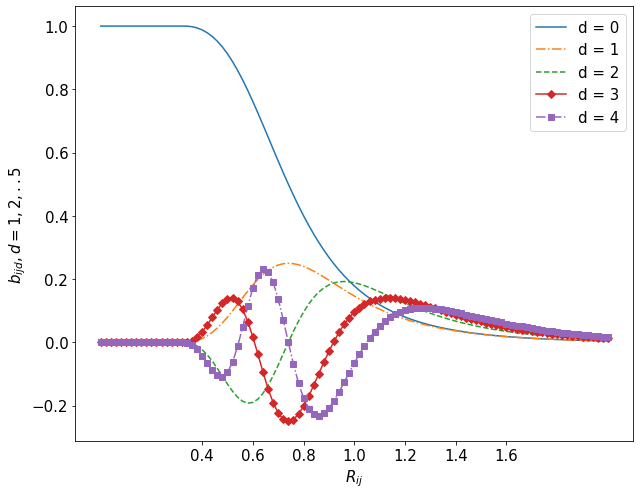

In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10, 8))
shapes = ["-","-.","--","-D", "-.s"]
legends = []
for d in range(5):
    plt.plot(R, b_ijd_mat[d], shapes[d])
    legends.append("d = "+str(d))
plt.xticks(np.linspace(0.4, 1.6, 7))
plt.legend(legends)
plt.xlabel('$R_{ij}$')
plt.ylabel('$b_{ijd}, d=1,2,..5$')

#### Bonding features of section 8.6, pg. 68

In [37]:
b_ijd_mat_list = []
R = [np.linspace(0, 25, 1001), np.linspace(0, 17.5, 1001)]
e = [2.5, 3]; R_m = [1.9, 2.1]; R_low = [5e-4, 9.1e-5]; R_up = [27.7, 17.9];
for k in range(len(R)):
    t0 = t_R_fun(R_m[k], R_up[k], R_low[k], e[k]) #scalar
    t = t_R_fun(R[k], R_up[k], R_low[k], e[k]) #vector (len(R))
    s = np.array([s_bond_strength(R[k][i], R_up[k], R_low[k], t[i], t0) for i in range(R[k].shape[0])]) #vec (len(R))
    s_prime = s_prime_fun(s) #vec len(R)
    b_ijd_mat_list.append(np.array([p_tchebyshev_pol(deg, s, s_prime) for deg in range(1, 6)])) #matrix (5 (d) x len(R))

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


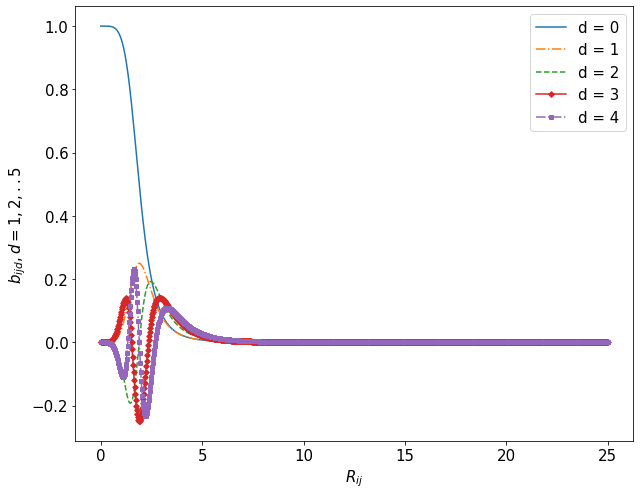

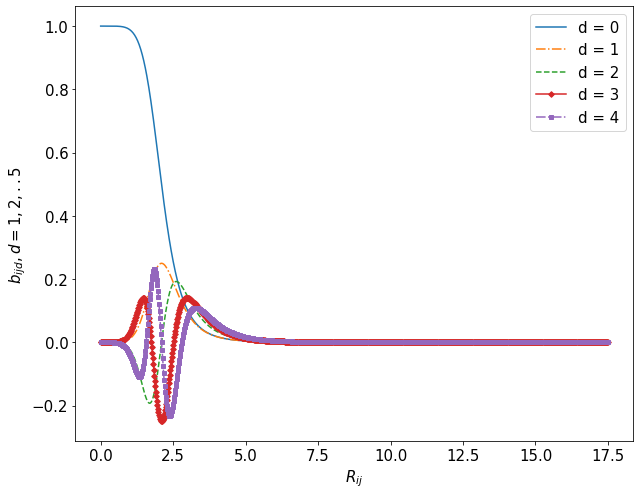

In [38]:
for k in range(len(R)):
    plt.rcParams.update({'font.size': 15})
    fig = plt.figure(figsize=(10, 8))
    for d in range(5):
        plt.plot(R[k], b_ijd_mat_list[k][d], shapes[d], markersize=4)
        dplot = d+1
        legends.append("d = "+str(dplot))
    #plt.xticks(np.linspace(0.4, 1.6, 7))
    plt.legend(legends)
    plt.xlabel('$R_{ij}$')
    plt.ylabel('$b_{ijd}, d=1,2,..5$')

#### Dataset for 8.5: fig.9 and 10, pg. 34-35

In [ ]:
R_mat_list = []
file_list = ["H3_mielke_main.txt", ""]